# Projet 7: Implémentez un modèle de scoring

## Notebook modélisation pour transfer sur GitHUb

# Version en évolution 

## <font color="#0000FF">Sommaire</font>

1. [Analyse des datasets et pré-processing](#section_1)<br>
    1.1. [Visualisation databases](#section_1_1)<br>
    1.2. [Pré-processing "application_train"](#section_1_2)<br>
    1.3. [Pré-processing "bureau.csv" & "bureau_balance.csv" + fusion](#section_1_3)<br>
    1.4. [Pré-processing "previous_applications.csv" + fusion](#section_1_4)<br>
    1.5. [Pré-processing "POS_CASH_balance.csv" + fusion](#section_1_5)<br>
    1.6. [Pré-processing "installments_payments.csv" + fusion](#section_1_6)<br>
    1.7. [Pré-processing "credit_card_balance.csv" + fusion](#section_1_7)   
    1.8. [Pré-processing "application_test" + fusion all dataframes](#section_1_8)<br>
    
  
2. [Features importance selection](#section_2)<br>
    2.1. [Features selection : spécifiques à l'algorithme LIGHTGBM](#section_2_1)    
    2.2. [Features selection : globale SHAP avec permutation importance](#section_2_2)  
    2.3. [Selection finale features pour modélisation](#section_2_3)<br>
    
    
3. [Simulation des modéles ML](#section_3)<br>
    3.1. [Features selection : avec LIGHTGBM](#section_3_1)    
    3.2. [Features selection : avec permutation importance](#section_3_2)  
    3.3. [Selection finale features pour modélisation](#section_3_3)<br>
    3.4. [SCORING: Predictions-Probabilités-Données clients](#section_3_4)<br>      


In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import display, display_html, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [2]:
# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [3]:
import os
os.chdir('C:\\Users\\Gabriela\\Documents\\OCR\\P7\\Soutenance\\')

In [ ]:
# le module pickle permet de sauvegarder dans un fichier, au format binaire,  n'importe quel objet Python.
# Il permet de stocker et de restaurer un objet Python tel quel sans aucune manipulation supplémentaire
# utilisation pickle

# Version 1:
# ouvrir le fichier d'enregistrement en mode "wb"
f = open(chemin du fichier,"wb")

# dump: enregistrer une variable dans le fichier 
dump(nom de la variable, f)

# clese du fichier
f.close()


# Version 2:
# https://www.quennec.fr/trucs-astuces/langages/python/python-le-module-pickle
# ouvrir le fichier d'enregistrement en mode "wb" (binaire) pour sauvegarder l'objet L (avec methode dump)
with open('nom_du_fichier',"wb") as f:
    pickle.dump(L, f)

# attention la méthode load récupère les données au début du fichier, donc besoin d'ouvrir fichier en wb
with open('nom_du_fichier',"rb") as f:
    Obj=pickle.load(f)    
    
# lecture du fichier
with open('nom_du_fichier',"r") as f:
    f.read()

## <font color="#0000FF" id="section_1">1. Analyse des datasets et pré-processing</font>

### <font color="#0000FF" id="section_1_1">1.1. Visualisation databases</font>

In [42]:
homecredit = pd.read_csv("HomeCredit_columns_description.csv", delimiter = ",", encoding='cp1252')
pos_cash_balance = pd.read_csv("POS_CASH_balance.csv", delimiter = ",")
bureau = pd.read_csv("bureau.csv", delimiter = ",")
bureau_balance = pd.read_csv("bureau_balance.csv", delimiter = ",")
credit_card_balance = pd.read_csv("credit_card_balance.csv", delimiter = ",")
installm_paym = pd.read_csv("installments_payments.csv", delimiter = ",")
previous_appl = pd.read_csv("previous_application.csv", delimiter = ",")
sample_subm = pd.read_csv("sample_submission.csv", delimiter = ",")
appl_test = pd.read_csv("application_test.csv", delimiter = ",")
appl_train = pd.read_csv("application_train.csv", delimiter = ",")

In [6]:
display(HTML('<h3>homecredit: visualisation données</h3>'))
display("Ce fichier contient les descriptions des colonnes des différents fichiers de données")
display(homecredit.head(5))
display(homecredit.shape)
display()
display(HTML('<h3>bureau: visualisation données</h3>'))
display("Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau ")
display("Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande")
display(bureau.head(5))
display(bureau.shape)
display()
display(HTML('<h3>bureau_balance: visualisation données</h3>'))
display("Soldes mensuels des crédits précédents dans le Credit Bureau")
display("Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau ")
display(bureau_balance.head(5))
display(bureau_balance.shape)
display()
display(HTML('<h3>previous_appl: visualisation données</h3>'))
display("Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon")
display("Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données")
display(previous_appl.head(5))
display(previous_appl.shape)
display()
display(HTML('<h3>pos_cash_balance: visualisation données</h3>'))
display("Des instantanés mensuels des soldes des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit")
display("Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon ")
display(pos_cash_balance.head(5))
display(pos_cash_balance.shape)
display()
display(HTML('<h3>installm_paym: visualisation données</h3>'))
display("L'historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon")
display("Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué")
display("Une ligne est équivalente à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit de Home Credit précédent lié aux prêts de notre échantillon")
display(installm_paym.head(5))
display(installm_paym.shape)
display()
display(HTML('<h3>credit_card_balance: visualisation données</h3>'))
display("Instantanés des soldes mensuels des cartes de crédit antérieures que le demandeur possède chez Home Credit")
display("Ce tableau a une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon")
display(credit_card_balance.head(5))
display(credit_card_balance.shape)
display()
display(HTML('<h3>appl_train: visualisation données</h3>'))
display("Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)")
display("Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données")
display(appl_train.head(5))
display(appl_train.shape)
display()
display(HTML('<h3>appl_test: visualisation données</h3>'))
display("Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)")
display("Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données")
display(appl_test.head(5))
display(appl_test.shape)
display()
display(HTML('<h3>sample_subm: visualisation données</h3>'))
display(sample_subm.head(5))
display(sample_subm.shape)

'Ce fichier contient les descriptions des colonnes des différents fichiers de données'

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

(219, 5)

"Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau "

'Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande'

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

(1716428, 17)

'Soldes mensuels des crédits précédents dans le Credit Bureau'

"Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau "

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

(27299925, 3)

'Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon'

'Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données'

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

(1670214, 37)

'Des instantanés mensuels des soldes des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit'

"Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon "

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

(10001358, 8)

"L'historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon"

'Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué'

"Une ligne est équivalente à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit de Home Credit précédent lié aux prêts de notre échantillon"

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

(13605401, 8)

'Instantanés des soldes mensuels des cartes de crédit antérieures que le demandeur possède chez Home Credit'

"Ce tableau a une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon"

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

(3840312, 23)

"Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)"

'Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

(307511, 122)

"Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)"

'Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données'

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

(48744, 121)

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

(48744, 2)

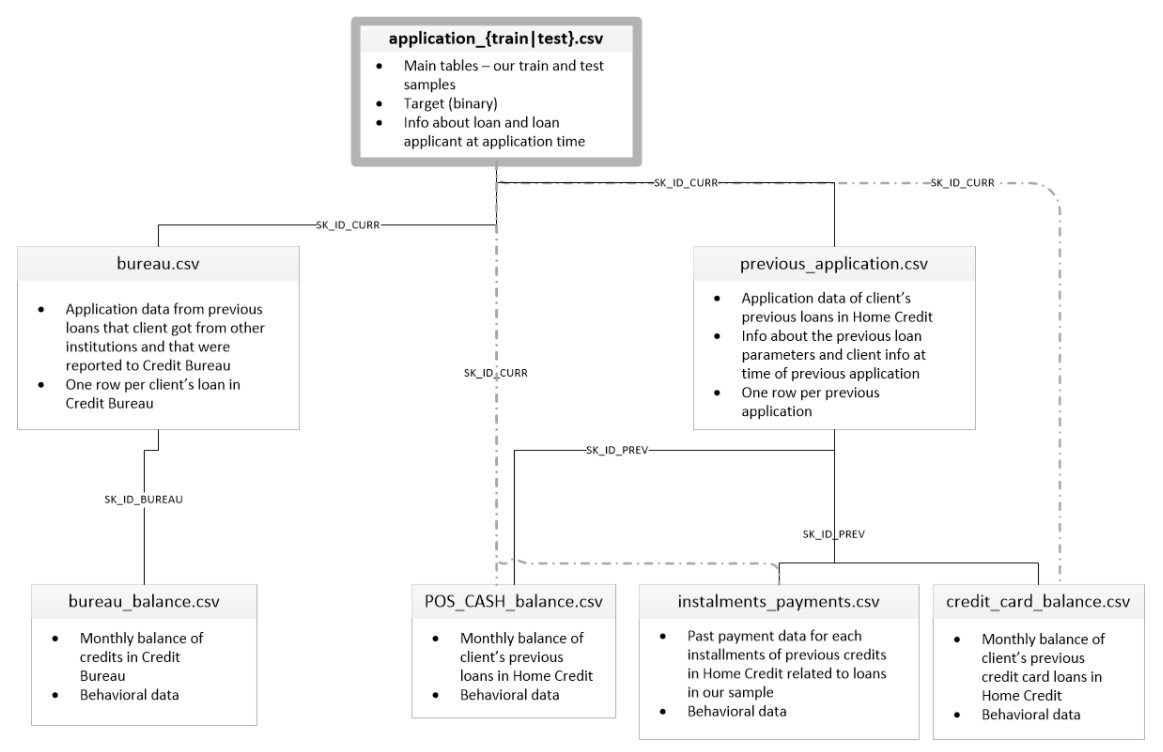

In [15]:
from IPython.display import Image
Image(filename='Application_explained.jpg', width=1800, height=400)

### Kaggles de reference:   "lightgbm_with_simple_features.py " et "Leodata"

In [25]:
# La plupart des caractéristiques sont créées en appliquant les fonctions min, max, mean, sum et var à des tableaux groupés. 
# Il y a peu de sélection de caractéristiques et l'ajustement excessif peut être un problème puisque de nombreuses caractéristiques sont liées.
# Les idées clés suivantes ont été utilisées :
# Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
# - Dans les données du bureau : créer des caractéristiques spécifiques pour les crédits actifs et les crédits fermés.
# Dans les demandes précédentes : créer des caractéristiques spécifiques pour les demandes approuvées et refusées.
# Modularité : une fonction pour chaque table (sauf bureau_balance et application_test).
# - Encodage unique pour les caractéristiques catégorielles
# Toutes les tables sont jointes avec l'application DF en utilisant la clé SK_ID_CURR (sauf bureau_balance).
# Vous pouvez utiliser LightGBM avec KFold ou KFold stratifié.

# Mise à jour 16/06/2018 :
# - Ajout de la fonctionnalité Taux de paiement.
# - Suppression de l'indice des caractéristiques
# - Utilisation du CV KFold standard (non stratifié)

## Définition fonctions

In [167]:
def describe_columns_df(df):
    """
    Affiche la description détaillée du contenu de chaque colonne de df
    df(pd.Dataframe): jeu de données
    """
    for col in df:
        print(col)
        null = df[col].isnull().sum()
        # affiche le nombre de valeurs manquantes
        print('Number of empty : ', null)
        # affiche le pourcentage de valeurs manquantes
        print('Percent of empty : ', 100*null/df.shape[0])
        print(df[col].describe())
        if df[col].dtype == object:
            print('Categories and Count:')
            print(df[col].value_counts().to_string(header=None))
        print('\n')

In [6]:
# Affiche la description détaillée du contenu de chaque colonne du jeu d'entrainement
describe_columns_df(appl_train)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean     278180.518577
std      102790.175348
min      100002.000000
25%      189145.500000
50%      278202.000000
75%      367142.500000
max      456255.000000
Name: SK_ID_CURR, dtype: float64


TARGET
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count         307511
unique             2
top       Cash loans
freq          278232
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         278232
Revolving loans     29279


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     307511
unique         3
top            F
freq      202448
Name: CODE_GENDER, dtype: object
Categories and Count:
F      202448


TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181


HOUR_APPR_PROCESS_START
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean         12.063419
std           3.265832
min           0.000000
25%          10.000000
50%          12.000000
75%          14.000000
max          23.000000
Name: HOUR_APPR_PROCESS_START, dtype: float64


REG_REGION_NOT_LIVE_REGION
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.015144
std           0.122126
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: REG_REGION_NOT_LIVE_REGION, dtype: float64


REG_REGION_NOT_WORK_REGION
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.050769
std           0.219526
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
N

Number of empty :  156061
Percent of empty :  50.749729277977046
count    151450.000000
mean          0.117850
std           0.109076
min           0.000000
25%           0.058300
50%           0.086400
75%           0.148900
max           1.000000
Name: APARTMENTS_MEDI, dtype: float64


BASEMENTAREA_MEDI
Number of empty :  179943
Percent of empty :  58.515955526794166
count    127568.000000
mean          0.087955
std           0.082179
min           0.000000
25%           0.043700
50%           0.075800
75%           0.111600
max           1.000000
Name: BASEMENTAREA_MEDI, dtype: float64


YEARS_BEGINEXPLUATATION_MEDI
Number of empty :  150007
Percent of empty :  48.781019215572776
count    157504.000000
mean          0.977752
std           0.059897
min           0.000000
25%           0.976700
50%           0.981600
75%           0.986600
max           1.000000
Name: YEARS_BEGINEXPLUATATION_MEDI, dtype: float64


YEARS_BUILD_MEDI
Number of empty :  204488
Percent of empty :  66.49778

Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.000007
std           0.002550
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_12, dtype: float64


FLAG_DOCUMENT_13
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.003525
std           0.059268
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_13, dtype: float64


FLAG_DOCUMENT_14
Number of empty :  0
Percent of empty :  0.0
count    307511.000000
mean          0.002936
std           0.054110
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: FLAG_DOCUMENT_14, dtype: float64


FLAG_DOCUMENT_15
Number of empty :  0
Percent of empty :  0.0
count    307511.00000
mean          0.00121
std           0.03476
min           0.00000
25%   

In [68]:
def get_types_variables(df_work, types, type_par_var, graph):
    """ Permet un aperçu du type des variables
    Parameters
    ----------
    @param IN : df_work : dataframe, obligatoire
                types : Si True lance dtypes, obligatoire
                type_par_var : Si True affiche tableau des types de
                               chaque variable, obligatoire
                graph : Si True affiche pieplot de répartition des types
    @param OUT :None.
    """

    if types:
        # 1. Type des variables
        print("-------------------------------------------------------------")
        print("Type de variable pour chacune des variables\n")
        display(df_work.dtypes)

    if type_par_var:
        # 2. Compter les types de variables
        #print("Répartition des types de variable\n")
        values = df_work.dtypes.value_counts()
        nb_tot = values.sum()
        percentage = round((100 * values / nb_tot), 2)
        table = pd.concat([values, percentage], axis=1)
        table.columns = [
            'Nombre par type de variable',
            '% des types de variable']
        display(table[table['Nombre par type de variable'] != 0]
                .sort_values('% des types de variable', ascending=False)
                .style.background_gradient('seismic'))

    if graph:
        # 3. Schéma des types de variable
        # print("\n----------------------------------------------------------")
        #print("Répartition schématique des types de variable \n")
        # Répartition des types de variables
        df_work.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
        plt.ylabel('')
        plt.show()

In [69]:
def description_variables(dataframe, type_var='all'):
    """
    Retourne la description des variables qualitatives/quantitatives
    ou toutes les variables du dataframe transmis :
    type, nombre de nan, % de nan et desc
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                type_var = 'all' ==> tous les types de variables (défaut)
                           'cat' ==> variables catégorielles
                           'num' ==> variables quantitative
                           facultatif
    @param OUT : dataframe de description des variables
    """
    df_taille = dataframe.shape[0]

    if type_var == 'num':
        desc_var = dataframe.describe(datetime_is_numeric=True)
    elif type_var == 'cat':
        desc_var = dataframe.describe(
            exclude=[np.number], datetime_is_numeric=True)
    else:
        desc_var = dataframe.describe(include='all', datetime_is_numeric=True)

    desc_type = pd.DataFrame(
        dataframe[desc_var.columns].dtypes, columns=['type']).T
    nb_nan = df_taille - desc_var.loc['count'].T
    pourcentage_nan = nb_nan * 100 / np.product(dataframe.shape)
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                            index=['nb_nan', '%_nan'])
    desc_var = pd.concat([desc_type, desc_nan, desc_var])

    return desc_var

In [70]:
# Afficher des informations sur les valeurs manquantes

def get_missing_values(df_work, pourcentage, affiche_heatmap, retour=False):
    """Indicateurs sur les variables manquantes
       @param in : df_work dataframe obligatoire
                   pourcentage : boolean si True affiche le nombre heatmap
                   affiche_heatmap : boolean si True affiche la heatmap
       @param out : none
    """

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df_work.isna().sum().sum()
    nb_donnees_tot = np.product(df_work.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes : {nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes
        # par variable
        values = df_work.isnull().sum()
        percentage = 100 * values / len(df_work)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
                .style.background_gradient('seismic'))

    if affiche_heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df_work.isna(), cbar=False)
        plt.show()

    if retour:
        return table

In [171]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### <font color="#0000FF" id="section_1_2">1.2. Pré-processing "application_train"</font>

<span style='background:PaleGreen'>**Description**</span>

- Le fichier application_train.csv est constituée de données statiques relatives aux emprunteurs avec des étiquettes. 
- Chaque ligne représente une demande de prêt.

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

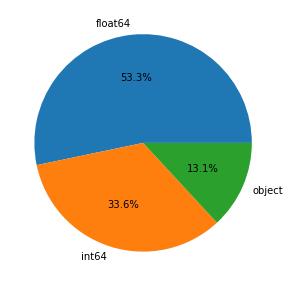

In [10]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(appl_train, True, False, True)

In [15]:
# Résumé des variables
desc_appl_train = description_variables(appl_train)
desc_appl_train

SK_ID_CURR    TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type            int64     int64             object      object       object   
nb_nan            0.0       0.0                0.0         0.0          0.0   
%_nan             0.0       0.0                0.0         0.0          0.0   
count        307511.0  307511.0             307511      307511       307511   
unique            NaN       NaN                  2           3            2   
top               NaN       NaN         Cash loans           F            N   
freq              NaN       NaN             278232      202448       202924   
mean    278180.518577  0.080729                NaN         NaN          NaN   
std     102790.175348  0.272419                NaN         NaN          NaN   
min          100002.0       0.0                NaN         NaN          NaN   
25%          189145.5       0.0                NaN         NaN          NaN   
50%          278202.0       0.0                NaN         NaN          NaN   
75%          367142.5       0.0                NaN         NaN          NaN   
max          456255.0       1.0                NaN         NaN          NaN   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL     AMT_CREDIT  \
type            object        int64          float64        float64   
nb_nan             0.0          0.0              0.0            0.0   
%_nan              0.0          0.0              0.0            0.0   
count           307511     307511.0         307511.0       307511.0   
unique               2          NaN              NaN            NaN   
top                  Y          NaN              NaN            NaN   
freq            213312          NaN              NaN            NaN   
mean               NaN     0.417052    168797.919297  599025.999706   
std                NaN     0.722121    237123.146279  402490.776996   
min                NaN          0.0          25650.0        45000.0   
25%                NaN          0.0         112500.0       270000.0   
50%                NaN          0.0         147150.0       513531.0   
75%                NaN          1.0         202500.0       808650.0   
max                NaN         19.0      117000000.0      4050000.0   

         AMT_ANNUITY  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
type         float64  ...            int64            int64            int64   
nb_nan          12.0  ...              0.0              0.0              0.0   
%_nan       0.000032  ...              0.0              0.0              0.0   
count       307499.0  ...         307511.0         307511.0         307511.0   
unique           NaN  ...              NaN              NaN              NaN   
top              NaN  ...              NaN              NaN              NaN   
freq             NaN  ...              NaN              NaN              NaN   
mean    27108.573909  ...          0.00813         0.000595         0.000507   
std     14493.737315  ...         0.089798         0.024387         0.022518   
min           1615.5  ...              0.0              0.0              0.0   
25%          16524.0  ...              0.0              0.0              0.0   
50%          24903.0  ...              0.0              0.0              0.0   
75%          34596.0  ...              0.0              0.0              0.0   
max         258025.5  ...              1.0              1.0              1.0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
type              int64                    float64                   float64   
nb_nan              0.0                    41519.0                   41519.0   
%_nan               0.0                   0.110669                  0.110669   
count          307511.0                   265992.0                  265992.0   
unique              NaN                        NaN                       NaN   
top                 NaN                        NaN                       NaN  

In [17]:
len(appl_train['SK_ID_CURR'].unique())

307511

**Bilan** :
***
- Le fichier application_train.csv contient environ **307511 enregistrements** et **122 variables**. 
- Ces variables contiennent les **statistiques personnelles d'un demandeur particulier**, telles que son âge, ses revenus, le type de prêt, les statistiques de son appartement, etc.
- Il y a **307511 SK_ID_CURR uniques** qui représentent des demandes de prêt uniques.
- Le champ **TARGET** représente le **statut de défaut de paiement du prêt** :
    - 0 pour non défaillant,
    - et 1 pour défaillant.

## Variable TARGET

In [11]:
appl_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [12]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=90)
    plt.show()

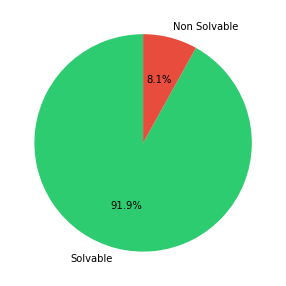

In [13]:
# Pieplot solvabilité clients du jeu d'entrainement
rcParams['figure.figsize'] = 5, 5
solvability_clients(appl_train)

In [21]:
# Valeurs manquantes du dataframe appl_train
get_missing_values(appl_train, True, False, True)

Valeurs manquantes : 9152465 NaN pour 37516342 données (24.4 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
SK_ID_CURR                                              0   
TARGET                                                  0   
NAME_CONTRACT_TYPE                                      0   
CODE_GENDER                                             0   
FLAG_OWN_CAR                                            0   
...                                                   ...   
AMT_REQ_CREDIT_BUREAU_DAY                           41519   
AMT_REQ_CREDIT_BUREAU_WEEK                          41519   
AMT_REQ_CREDIT_BUREAU_MON                           41519   
AMT_REQ_CREDIT_BUREAU_QRT                           41519   
AMT_REQ_CREDIT_BUREAU_YEAR                          41519   

                            % de valeurs manquantes  
SK_ID_CURR                                      0.0  
TARGET                                          0.0  
NAME_CONTRACT_TYPE                              0.0  
CODE_GENDER                                     0.0  
FLAG_OWN_CAR                                    0.0  
...                                             ...  
AMT_REQ_CREDIT_BUREAU_DAY                      13.5  
AMT_REQ_CREDIT_BUREAU_WEEK                     13.5  
AMT_REQ_CREDIT_BUREAU_MON                      13.5  
AMT_REQ_CREDIT_BUREAU_QRT                      13.5  
AMT_REQ_CREDIT_BUREAU_YEAR                     13.5  

[122 rows x 2 columns]

### conclusion: top 20 des variables explicatives pour la variable cible 'TARGET'

In [27]:
corr_matr = appl_train.corr()
abs(corr_matr['TARGET']).sort_values(ascending=False)[:21]

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
REGION_POPULATION_RELATIVE     0.037227
Name: TARGET, dtype: float64

**Bilan** :
- Parmi toutes les variables, nous constatons une corrélation élevée pour les variables EXT_SOURCE par rapport à la variable cible. Celles-ci peuvent être importantes pour la tâche de classification.

## Constat: application_train=(307511, 122) et application_test=(48744, 121) , n'ont pas le meme nb de variables
## Conclusion: seulement application_train contient les classes = variable 'TARGET' + sera utilisé pour le modéle 

## Preprocess application_train.csv et introduction des variables métier/features engineering

In [39]:
def application_train_cleaned(num_rows = None, nan_as_category = False):
    # Read data 
    application_train = pd.read_csv('application_train.csv', nrows= num_rows)
    print("Train samples: {}".format(len(application_train)))
    # Suppression de 4 clients avec sexe non renseigné, XNA CODE_GENDER (train set)
    application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
    # Suppression de 5 clients  'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour 5 emprunters
    application_train = application_train[application_train['NAME_INCOME_TYPE'] != 'Maternity leave']
    # Suppression de 2 clients ayant  la colonne NAME_FAMILY_STATUS la valeur Unknown 
    application_train = application_train[application_train['NAME_FAMILY_STATUS'] != 'Unknown']
    
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        application_train[bin_feature], uniques = pd.factorize(application_train[bin_feature])
    # Categorical features with One-Hot encode
    application_train, cat_cols = one_hot_encoder(application_train, nan_as_category)
    
    # Correction valeurs aberantes: Nan pour DAYS_EMPLOYED: (18% lignes) 365243 (=1000 ans)-> nan
    application_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Nouvelles Features Engineering (percentages), variables métier, pour aider le modéle:
    # Le ratio temps travaillé/âge
    # Le ratio crédit/revenu
    # le ratio crédit/annuité/âge
    # le ratio revenu/annuité
    # le ratio crédit/annuité
    application_train['DAYS_EMPLOYED_PERC'] = application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']
    application_train['INCOME_CREDIT_PERC'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
    application_train['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
    application_train['ANNUITY_INCOME_PERC'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']
    application_train['PAYMENT_RATE'] = application_train['AMT_ANNUITY'] / application_train['AMT_CREDIT']
    # del test_df
    gc.collect()
    return application_train

In [40]:
appl_train_new = application_train_cleaned(num_rows = None, nan_as_category = False)
appl_train_new

Train samples: 307511


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1            0             0                0   
1           100003       0            1             0                1   
2           100004       0            0             1                0   
3           100006       0            1             0                0   
4           100007       0            0             0                0   
...            ...     ...          ...           ...              ...   
307506      456251       0            0             0                1   
307507      456252       0            1             0                0   
307508      456253       0            1             0                0   
307509      456254       1            1             0                0   
307510      456255       0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Panel  \
0              351000.0  ...                         0   
1             1129500.0  ...                         0   
2              135000.0  ...                         0   
3              297000.0  ...                         0   
4              513000.0  ...                         0   
...                 ...  ...                       ...   
307506         225000.0  ...                         0   
307507         225000.0  ...                         0   
307508         585000.0  ...                         1   
307509         319500.0  ...                         0   
307510         675000.0  ...                         1   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                     1                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   
...                                 ...                        ...   
307506                                1                          0   
307507                                1                          0   
307508                                0                          0   
307509                                1                          0   
307510                                0                          0   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
0                            1                        0            0.067329   
1                            1                        0            0.070862   
2                            0                        0            0.011814   
3                            0                        0            0.159905   
4                            0                        0            0.152418   
...                        ...                      ...                 ...   
307506                       1                        0            0.025303   
307507                       1                        0                 NaN   
307508                       1                        0          

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR               int64
TARGET                   int64
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
                        ...   
DAYS_EMPLOYED_PERC     float64
INCOME_CREDIT_PERC     float64
INCOME_PER_PERSON      float64
ANNUITY_INCOME_PERC    float64
PAYMENT_RATE           float64
Length: 245, dtype: object

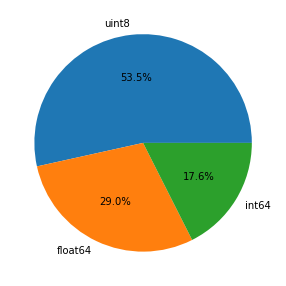

In [30]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(appl_train_new, True, False, True)

### Données manquantes

#### Proportions des données manquantes

In [31]:
# Valeurs manquantes du dataframe appl_train_new
df_nan_appl_train = get_missing_values(appl_train_new, True, False, True)

Valeurs manquantes : 8498545 NaN pour 75337500 données (11.28 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



* Parmi les variables importantes repérées lors de l'analyse exploratoire pour départager les non-défaillants des défaillants, la variable FLOORSMIN_AVG est celle qui a le plus de valeurs manquantes (67.85%).
* On fixera le seuil de suppression des variables ayant de nombreuses valeurs manquantes à 68%.

In [41]:
# Liste des variables ayant plus de 68% de valeurs manquantes
cols_nan_a_suppr = \
    df_nan_appl_train[df_nan_appl_train['% de valeurs manquantes'] > 68] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr)}')
cols_nan_a_suppr

Nombre de variables à supprimer : 9


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI']

In [42]:
# Suppression des variables avec un seuil de nan > 68%
appl_train_new.drop(columns=cols_nan_a_suppr, inplace=True)
# Taille : nombre de lignes/colonnes
nRow, nVar = appl_train_new.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 307500 lignes et 236 variables.


### Remplacement des valeurs manquantes des variables importantes pour la cible 'TARGET'

**Super variable du gagnant du concours Kaggle**
- Imputation de la moyenne des 500 valeurs cibles des voisins les plus proches pour chaque application du train set ou test set.
- Les voisins sont calculés en utilisant :
    - les variables très importantes :
        - EXT_SOURCE-1, 
        - EXT_SOURCE_2 
        - et EXT_SOURCE_3,
    - et PAYMENT_RATE (ratio du l'Annuité de prêt/Montant du crédit du prêt).
[Source](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821) 

In [47]:
from sklearn.neighbors import KNeighborsClassifier

def feature_engineering_neighbors_EXT_SOURCE(dataframe):
    '''
     - Imputation de la moyenne des 500 valeurs cibles des voisins les plus
       proches pour chaque application du train set ou test set.
     - Les voisins sont calculés en utilisant :
       - les variables très importantes :
       - EXT_SOURCE-1,
       - EXT_SOURCE_2
       - et EXT_SOURCE_3,
     - et PAYMENT_RATE (ratio du Montant du crédit du prêt / Annuité de prêt).
     [Source](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821)
     Inputs: dataframe pour lequel on veut ajouter la variable des 500 plus
             proches voisins.
     Returns:
         None
     '''

    knn = KNeighborsClassifier(500, n_jobs=-1)

    train_data_for_neighbors = dataframe[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                          'EXT_SOURCE_3',
                                          'PAYMENT_RATE']].fillna(0)

    # saving the training data for neighbors
    # with open('../sauvegarde/pre-processing/TARGET_MEAN_500_Neighbors_training_data.pkl', 'wb') as f:
    #      pickle.dump(train_data_for_neighbors, f)
    train_target = dataframe.TARGET

    knn.fit(train_data_for_neighbors, train_target)
    # pickling the knn model
    # with open('../sauvegarde/pre-processing/KNN_model_TARGET_500_neighbors.pkl', 'wb') as f:
    #      pickle.dump(knn, f)

    train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]

    # adding the means of targets of 500 neighbors to new column
    dataframe['TARGET_NEIGHBORS_500_MEAN'] = [
        dataframe['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]

In [48]:
# Feature engineering super variable pour le dataframe application_train
feature_engineering_neighbors_EXT_SOURCE(appl_train_new)
appl_train_new.shape

(307500, 237)

**Variables quantitatives /Imputation par median**

In [51]:
# Variables quantitatives
cols_num = appl_train_new.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num

['SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_B

In [52]:
# Variables quantitatives - imputation par médiane
# Nous imputerons donc les valeurs manquantes des variables quantitatives par la valeur médiane 
# de chacune de ces variables puisque nous avons découvert lors de l'analyse exploratoire qu'il y avait de nombreux outliers
nb_nan_appl_train_median = appl_train_new[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_appl_train_median}')
appl_train_new.fillna(appl_train_new[cols_num].median(), inplace=True)
# Vérification
nb_nan_appl_train_median = appl_train_new[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_appl_train_median}')

Nombre de nan avant imputation par median : 6582886
Nombre de nan après imputation par median : 0


In [50]:
corr_matr_train_new = appl_train_new.corr()
abs(corr_matr_train_new['TARGET']).sort_values(ascending=False)[:21]

TARGET                                               1.000000
TARGET_NEIGHBORS_500_MEAN                            0.244860
EXT_SOURCE_3                                         0.178926
EXT_SOURCE_2                                         0.160451
EXT_SOURCE_1                                         0.155333
DAYS_BIRTH                                           0.078236
DAYS_EMPLOYED                                        0.074973
DAYS_EMPLOYED_PERC                                   0.067974
REGION_RATING_CLIENT_W_CITY                          0.060875
REGION_RATING_CLIENT                                 0.058882
NAME_INCOME_TYPE_Working                             0.057504
NAME_EDUCATION_TYPE_Higher education                 0.056578
DAYS_LAST_PHONE_CHANGE                               0.055228
CODE_GENDER                                          0.054729
DAYS_ID_PUBLISH                                      0.051455
REG_CITY_NOT_WORK_CITY                               0.050981
NAME_EDU

In [53]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr = appl_train_new.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

<ipython-input-53-5768d785931d>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [54]:
# Variables avec un coef de Pearson > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

39 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAREA_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAREA_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
NAME_CONTRACT_TYPE_Revolving loans
NAME_INCOME_TYPE_Pensioner
NAME_EDUCATION_TYPE_Secondary / secondary special
ORGANIZATION_TYPE_XNA
EMERGENCYSTATE_MODE_No
DAYS_EMPLOYED_PERC
INCOME_PER_PERSON


In [56]:
# Suppression des variables fortement corrélées
print(f'application_train_all : {appl_train_new.shape}')
appl_train_new.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train_cleaned : {appl_train_new.shape}')

application_train_all : (307500, 237)
application_train_cleaned : (307500, 198)


In [57]:
# Sauvegarde de application_train nettoyée, encodée, prête pour ML
appl_train_new.to_csv("appl_train_cleaned.csv", index=False)

In [59]:
appl_train_cleaned = pd.read_csv("appl_train_cleaned.csv")

In [60]:
appl_train_cleaned

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1            0             0                0   
1           100003       0            1             0                1   
2           100004       0            0             1                0   
3           100006       0            1             0                0   
4           100007       0            0             0                0   
...            ...     ...          ...           ...              ...   
307495      456251       0            0             0                1   
307496      456252       0            1             0                0   
307497      456253       0            1             0                0   
307498      456254       1            1             0                0   
307499      456255       0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307495             0          157500.0    254700.0      27558.0   
307496             0           72000.0    269550.0      12001.5   
307497             0          153000.0    677664.0      29979.0   
307498             0          171000.0    370107.0      20205.0   
307499             0          157500.0    675000.0      49117.5   

        REGION_POPULATION_RELATIVE  ...  WALLSMATERIAL_MODE_Monolithic  \
0                         0.018801  ...                              0   
1                         0.003541  ...                              0   
2                         0.010032  ...                              0   
3                         0.008019  ...                              0   
4                         0.028663  ...                              0   
...                            ...  ...                            ...   
307495                    0.032561  ...                              0   
307496                    0.025164  ...                              0   
307497                    0.005002  ...                              0   
307498                    0.005313  ...                              0   
307499                    0.046220  ...                              0   

        WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   
...                           ...                       ...   
307495                          0                         0   
307496                          0                         0   
307497                          0                         1   
307498                          0                         0   
307499                          0                         1   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                     1                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   
...                                 ...                        ...   
307495                                1                          0   
307496                                1                          0   
307497                                

### <font color="#0000FF" id="section_1_3">1.3. Pré-processing "bureau.csv" & "bureau_balance.csv" + fusion</font>

<span style='background:PaleGreen'>**Description**</span>

- Le fichier **bureau.csv** comprend tous les **antécédents de crédit antérieurs du demandeur auprès d'institutions financières autres que le Home Credit Group**, qui ont été signalés par le bureau de crédit.
- Le fichier **bureau_balance.csv** est constitué du solde mensuel de chaque crédit pour chacun des crédits précédents que le demandeur a eu avec des institutions financières autres que Home Credit.

In [63]:
# Valeurs manquantes du dataframe bureau 
df_nan_bureau = get_missing_values(bureau, True, False, True)

Valeurs manquantes : 3939947 NaN pour 29179276 données (13.5 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

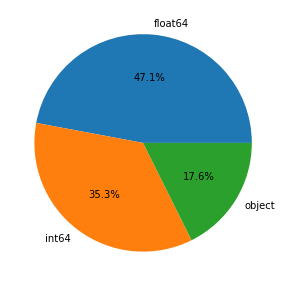

In [65]:
# Types des variables
get_types_variables(bureau, True, True, True)

In [64]:
# Valeurs manquantes du dataframe bureau_balance
df_nan_bureau_balance = get_missing_values(bureau_balance, True, False, True)

Valeurs manquantes : 0 NaN pour 81899775 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

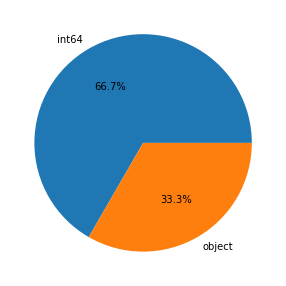

In [66]:
# Types des variables
get_types_variables(bureau_balance, True, True, True)

In [189]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bureau_balance = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bureau_balance, bureau_balance_cat = one_hot_encoder(bureau_balance, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bureau_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bureau_balance_cat:
        bureau_balance_aggregations[col] = ['mean']
    bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)
    bureau_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_balance_agg.columns.tolist()])
    bureau = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bureau_balance, bureau_balance_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features = Variables METIERS
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bureau_balance_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [190]:
bureau_agg = bureau_and_balance(num_rows = None, nan_as_category = True)
bureau_agg = bureau_agg.reset_index()
bureau_agg

SK_ID_CURR  BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  \
0           100001                 -1572                   -49   
1           100002                 -1437                  -103   
2           100003                 -2586                  -606   
3           100004                 -1326                  -408   
4           100005                  -373                   -62   
...            ...                   ...                   ...   
305806      456249                 -2713                  -483   
305807      456250                 -1002                  -760   
305808      456253                  -919                  -713   
305809      456254                 -1104                 -1104   
305810      456255                 -2337                  -363   

        BURO_DAYS_CREDIT_MEAN  BURO_DAYS_CREDIT_VAR  \
0                 -735.000000         240043.666667   
1                 -874.000000         186150.000000   
2                -1400.750000         827783.583333   
3                 -867.000000         421362.000000   
4                 -190.666667          26340.333333   
...                       ...                   ...   
305806           -1667.076923         407302.243590   
305807            -862.000000          15724.000000   
305808            -867.500000          10609.000000   
305809           -1104.000000                   NaN   
305810           -1089.454545         502786.672727   

        BURO_DAYS_CREDIT_ENDDATE_MIN  BURO_DAYS_CREDIT_ENDDATE_MAX  \
0                            -1329.0                        1778.0   
1                            -1072.0                         780.0   
2                            -2434.0                        1216.0   
3                             -595.0                        -382.0   
4                             -128.0                        1324.0   
...                              ...                           ...   
305806                       -2499.0                        1363.0   
305807                        -272.0                        2340.0   
305808                        -189.0                        1113.0   
305809                        -859.0                        -859.0   
305810                       -1243.0                       27320.0   

        BURO_DAYS_CREDIT_ENDDATE_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  \
0                           82.428571                    -93.142857   
1                         -349.000000                   -499.875000   
2                         -544.500000                   -816.000000   
3                         -488.500000                   -532.000000   
4                          439.333333                    -54.333333   
...                               ...                           ...   
305806                   -1232.333333                  -1064.538462   
305807                    1288.333333                    -60.333333   
305808                     280.500000                   -253.250000   
305809                    -859.000000                   -401.000000   
305810                    3231.272727                   -531.090909   

        BURO_CREDIT_DAY_OVERDUE_MAX  ...  CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN  \
0                                 0  ...                                 0.0   
1                                 0  ...                                 0.0   
2                                 0  ...                                 0.0   
3                                 0  ...                                 0.0   
4                                 0  ...                                 0.0   
...                             ...  ...                                 ...   
305806                            0  ...                                 0.0   
305807                            0  ...                                 0.0   
305808                            0  ...                                 0.0   
305809                            0  ...                    

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                           int64
BURO_DAYS_CREDIT_MIN                 int64
BURO_DAYS_CREDIT_MAX                 int64
BURO_DAYS_CREDIT_MEAN              float64
BURO_DAYS_CREDIT_VAR               float64
                                    ...   
CLOSED_CNT_CREDIT_PROLONG_SUM      float64
CLOSED_MONTHS_BALANCE_MIN_MIN      float64
CLOSED_MONTHS_BALANCE_MAX_MAX      float64
CLOSED_MONTHS_BALANCE_SIZE_MEAN    float64
CLOSED_MONTHS_BALANCE_SIZE_SUM     float64
Length: 117, dtype: object

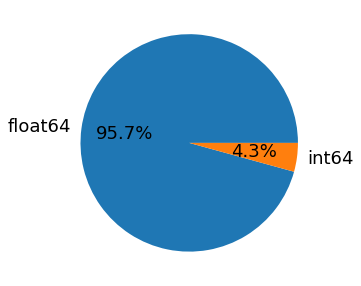

In [191]:
# Types des variables
get_types_variables(bureau_agg, True, True, True)

In [70]:
# Valeurs manquantes du dataframe appl_train
df_nan_bureau_agg = get_missing_values(bureau_agg, True, False, True)

Valeurs manquantes : 7152780 NaN pour 35779887 données (19.99 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



# Fusion avec train_cleaned et nettoyage variables fortement correlées

In [72]:
# jointure appl_train (application_train_cleaned) et bureau_agg (bureau_and_balance)
joint_1 = pd.merge(appl_train_cleaned, bureau_agg, how='left', on='SK_ID_CURR')
joint_1.shape

(307500, 314)

In [192]:
# -- GESTION DES VARIABLES FORTEMENT COLINEAIRES

def suppr_var_colineaire(dataframe, seuil=0.8):
    '''
    Récupération de la liste des variables fortement corrélées supérieur
    au seuil transmis.
    Parameters
    ----------
    dataframe : dataframe à analyser, obligatoire.
    seuil : le seuil de colinéarité entre les variables (0.8 par défaut).
    Returns
    -------
    cols_corr_a_supp : liste des variables à supprimer.
    '''
    
    # Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
    # les corrélations positives et négatives séparément
    corr = dataframe.corr().abs()
    # On ne conserve que la partie supérieur à la diagonale pour n'avoir
    # qu'une seule fois les corrélations prisent en compte (symétrie axiale)
    corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                               .astype(np.bool))
    
    # Variables avec un coef de Pearson > 0.8?
    cols_corr_a_supp = [var for var in corr_triangle.columns
                        if any(corr_triangle[var] > seuil)]
    print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
    for var in cols_corr_a_supp:
        print(var)
        
    return cols_corr_a_supp

In [75]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_1 = suppr_var_colineaire(joint_1)

40 variables fortement corrélées à supprimer :

BURO_DAYS_CREDIT_MEAN
BURO_AMT_CREDIT_SUM_MEAN
BURO_AMT_CREDIT_SUM_SUM
BURO_AMT_CREDIT_SUM_DEBT_SUM
BURO_MONTHS_BALANCE_MIN_MIN
BURO_MONTHS_BALANCE_SIZE_MEAN
BURO_CREDIT_ACTIVE_Closed_MEAN
BURO_CREDIT_CURRENCY_currency 2_MEAN
BURO_CREDIT_TYPE_Credit card_MEAN
ACTIVE_DAYS_CREDIT_MAX
ACTIVE_DAYS_CREDIT_MEAN
ACTIVE_DAYS_CREDIT_ENDDATE_MAX
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN
ACTIVE_CREDIT_DAY_OVERDUE_MAX
ACTIVE_CREDIT_DAY_OVERDUE_MEAN
ACTIVE_AMT_CREDIT_SUM_MAX
ACTIVE_AMT_CREDIT_SUM_MEAN
ACTIVE_AMT_CREDIT_SUM_SUM
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN
ACTIVE_AMT_CREDIT_SUM_DEBT_SUM
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN
ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM
ACTIVE_AMT_ANNUITY_MEAN
ACTIVE_CNT_CREDIT_PROLONG_SUM
ACTIVE_MONTHS_BALANCE_MIN_MIN
ACTIVE_MONTHS_BALANCE_SIZE_MEAN
CLOSED_DAYS_CREDIT_MIN
CLOSED_DAYS_CREDIT_MEAN
CLOSED_DAYS_CREDIT_ENDDATE_MIN
CLOSED_DAYS_CREDIT_UPDATE_MEAN
CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN
CLOSED_AMT_CREDIT_SUM_M

<ipython-input-74-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [76]:
# Suppression des variables fortement corrélées du joint_1
joint_1 = joint_1.drop(columns=var_corr_joint_1)
print(f'joint_1 : {joint_1.shape}')

joint_1 : (307500, 274)


In [77]:
# Valeurs manquantes du dataframe joint_1
df_nan_joint_1 = get_missing_values(joint_1, True, False, True)

Valeurs manquantes : 7207861 NaN pour 84255000 données (8.55 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



### Imputation par médiane des valeurs Nan

In [78]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_1_median = joint_1.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_1_median}')
joint_1.fillna(joint_1.median(), inplace=True)
# Vérification
nb_nan_joint_1_median = joint_1.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_1_median}')

Nombre de nan avant imputation par median : 7207861
Nombre de nan après imputation par median : 0


In [81]:
joint_1.shape

(307500, 274)

In [79]:
# Sauvegarde de joint_1 nettoyée, encodée, prête pour ML
joint_1.to_csv("joint_1_cleaned.csv", index=False)

In [82]:
joint_1=pd.read_csv("joint_1_cleaned.csv")

### <font color="#0000FF" id="section_1_4">1.4. Pré-processing "previous_applications.csv" + fusion</font>

# Preprocess previous_applications.csv

<span style='background:PaleGreen'>**Description**</span>

- Le fichier **previous_application.csv** contient les données statiques du précédent prêt que le demmdeur a eu avec Home Credit. 

In [83]:
# Valeurs manquantes du dataframe bureau 
df_nan_previous_appl = get_missing_values(previous_appl, True, False, True)

Valeurs manquantes : 11109336 NaN pour 61797918 données (17.98 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

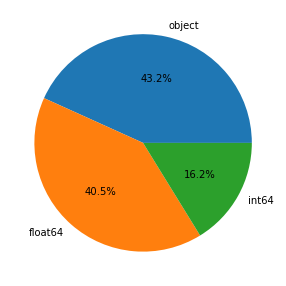

In [84]:
# Types des variables
get_types_variables(previous_appl, True, True, True)

In [198]:
def previous_applications(num_rows = None, nan_as_category = True):
    previous_appl = pd.read_csv('previous_application.csv', nrows = num_rows)
    previous_appl, cat_cols = one_hot_encoder(previous_appl, nan_as_category= True)
    # Suppression valeurs aberantes Days 365.243 values (1000 ans) -> nan     
    previous_appl['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Creation variable métier = feature: montant de crédit demandé lors de la demande précédente \
    # Montant final du crédit sur la demande précédente
    previous_appl['APP_CREDIT_PERC'] = previous_appl['AMT_APPLICATION'] / previous_appl['AMT_CREDIT']
    
    # Ajout des variables de statistiques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = previous_appl.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = previous_appl[previous_appl['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = previous_appl[previous_appl['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, previous_appl
    gc.collect()
    return prev_agg

In [199]:
prev_agg = previous_applications(num_rows = None, nan_as_category = True)
prev_agg = prev_agg.reset_index()
prev_agg

SK_ID_CURR  PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  \
0           100001              3951.000              3951.000   
1           100002              9251.775              9251.775   
2           100003              6737.310             98356.995   
3           100004              5357.250              5357.250   
4           100005              4813.200              4813.200   
...            ...                   ...                   ...   
338852      456251              6605.910              6605.910   
338853      456252             10074.465             10074.465   
338854      456253              3973.095              5567.715   
338855      456254              2296.440             19065.825   
338856      456255              2250.000             54022.140   

        PREV_AMT_ANNUITY_MEAN  PREV_AMT_APPLICATION_MIN  \
0                 3951.000000                   24835.5   
1                 9251.775000                  179055.0   
2                56553.990000                   68809.5   
3                 5357.250000                   24282.0   
4                 4813.200000                       0.0   
...                       ...                       ...   
338852            6605.910000                   40455.0   
338853           10074.465000                   57595.5   
338854            4770.405000                   19413.0   
338855           10681.132500                   18846.0   
338856           20775.391875                   45000.0   

        PREV_AMT_APPLICATION_MAX  PREV_AMT_APPLICATION_MEAN  \
0                        24835.5                  24835.500   
1                       179055.0                 179055.000   
2                       900000.0                 435436.500   
3                        24282.0                  24282.000   
4                        44617.5                  22308.750   
...                          ...                        ...   
338852                   40455.0                  40455.000   
338853                   57595.5                  57595.500   
338854                   28912.5                  24162.750   
338855                  223789.5                 121317.750   
338856                 1170000.0                 362770.875   

        PREV_AMT_CREDIT_MIN  PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  ...  \
0                   23787.0              23787.0              23787.00  ...   
1                  179055.0             179055.0             179055.00  ...   
2                   68053.5            1035882.0             484191.00  ...   
3                   20106.0              20106.0              20106.00  ...   
4                       0.0              40153.5              20076.75  ...   
...                     ...                  ...                   ...  ...   
338852              40455.0              40455.0              40455.00  ...   
338853              56821.5              56821.5              56821.50  ...   
338854              13945.5              27306.0              20625.75  ...   
338855              21456.0             247423.5             134439.75  ...   
338856              45000.0            1271929.5             424431.00  ...   

        REFUSED_HOUR_APPR_PROCESS_START_MAX  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
338852                                  NaN   
338853                                  NaN   
338854                                  NaN   
338855                                  NaN   
338856                                 14.0   

        REFUSED_HOUR_APPR_PROCESS_START_MEAN  REFUSED_RATE_DOWN_PAYMENT_MIN  \
0                                        NaN                            NaN   
1                                        NaN                            NaN  

In [87]:
# Valeurs manquantes du dataframe prev_agg 
df_nan_prev_agg = get_missing_values(prev_agg, True, False, True)

Valeurs manquantes : 7608407 NaN pour 84714250 données (8.98 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



# Fusion avec train_cleaned et nettoyage variables fortement correlées

In [88]:
# Fusion joint_1 (application_train_cleaned) et prev_agg 
joint_2 = pd.merge(joint_1, prev_agg, how='left', on='SK_ID_CURR')
joint_2.shape

(307500, 523)

In [89]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_2 = suppr_var_colineaire(joint_2)

81 variables fortement corrélées à supprimer :

PREV_AMT_ANNUITY_MEAN
PREV_AMT_APPLICATION_MAX
PREV_AMT_CREDIT_MIN
PREV_AMT_CREDIT_MAX
PREV_AMT_CREDIT_MEAN
PREV_AMT_DOWN_PAYMENT_MEAN
PREV_AMT_GOODS_PRICE_MAX
PREV_AMT_GOODS_PRICE_MEAN
PREV_HOUR_APPR_PROCESS_START_MEAN
PREV_RATE_DOWN_PAYMENT_MEAN
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN
PREV_NAME_PAYMENT_TYPE_XNA_MEAN
PREV_CODE_REJECT_REASON_CLIENT_MEAN
PREV_CODE_REJECT_REASON_XAP_MEAN
PREV_NAME_CLIENT_TYPE_Repeater_MEAN
PREV_NAME_GOODS_CATEGORY_XNA_MEAN
PREV_NAME_PORTFOLIO_Cards_MEAN
PREV_NAME_PORTFOLIO_Cash_MEAN
PREV_NAME_PORTFOLIO_POS_MEAN
PREV_NAME_PORTFOLIO_XNA_MEAN
PREV_NAME_PRODUCT_TYPE_XNA_MEAN
PREV_CHANNEL_TYPE_Car dealer_MEAN
PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN
PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN
PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN
PREV_NAME_SELLER_INDUSTRY_XNA_MEAN
PREV_NAME_YIELD_GROUP_XNA_MEAN

<ipython-input-74-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [90]:
# Suppression des variables fortement corrélées du joint_2
joint_2 = joint_2.drop(columns=var_corr_joint_2)
print(f'joint_2 : {joint_2.shape}')

joint_2 : (307500, 442)


In [91]:
# Valeurs manquantes du dataframe joint_2
df_nan_joint_2 = get_missing_values(joint_2, True, False, True)

Valeurs manquantes : 5376562 NaN pour 135915000 données (3.96 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [92]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_2_median = joint_2.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_2_median}')
joint_2.fillna(joint_2.median(), inplace=True)
# Vérification
nb_nan_joint_2_median = joint_2.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_2_median}')

Nombre de nan avant imputation par median : 5376562
Nombre de nan après imputation par median : 0


In [93]:
joint_2.shape

(307500, 442)

In [94]:
# Sauvegarde de joint_2 nettoyée, encodée, prête pour ML
joint_2.to_csv("joint_2_cleaned.csv", index=False)

In [95]:
joint_2=pd.read_csv("joint_2_cleaned.csv")

### <font color="#0000FF" id="section_1_5">1.5. Pré-processing "POS_CASH_balance.csv" + fusion</font>

In [96]:
# Valeurs manquantes du dataframe pos_cash_balance 
df_nan_pos_cash_balance = get_missing_values(pos_cash_balance, True, False, True)

Valeurs manquantes : 52158 NaN pour 80010864 données (0.07 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

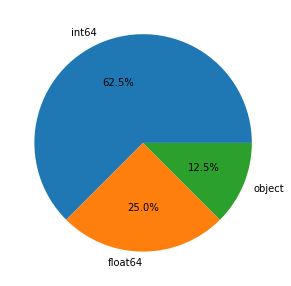

In [97]:
# Types des variables
get_types_variables(pos_cash_balance, True, True, True)

# Preprocess POS_CASH_balance.csv

In [206]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos_cash_balance = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos_cash_balance, cat_cols = one_hot_encoder(pos_cash_balance, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos_cash_balance.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos_cash_balance.groupby('SK_ID_CURR').size()
    del pos_cash_balance
    gc.collect()
    return pos_agg

In [207]:
pos_agg = pos_cash(num_rows = None, nan_as_category = True)
pos_agg = pos_agg.reset_index()
pos_agg

SK_ID_CURR  POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
0           100001                     -53               -72.555556   
1           100002                      -1               -10.000000   
2           100003                     -18               -43.785714   
3           100004                     -24               -25.500000   
4           100005                     -15               -20.000000   
...            ...                     ...                      ...   
337247      456251                      -1                -5.000000   
337248      456252                     -76               -79.000000   
337249      456253                     -57               -79.235294   
337250      456254                      -1                -5.550000   
337251      456255                      -2               -16.408451   

        POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
0                             9               7         0.777778   
1                            19               0         0.000000   
2                            28               0         0.000000   
3                             4               0         0.000000   
4                            11               0         0.000000   
...                         ...             ...              ...   
337247                        9               0         0.000000   
337248                        7               0         0.000000   
337249                       17               5         0.294118   
337250                       20               0         0.000000   
337251                       71               5         0.070423   

        POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
0                        7             0.777778   
1                        0             0.000000   
2                        0             0.000000   
3                        0             0.000000   
4                        0             0.000000   
...                    ...                  ...   
337247                   0             0.000000   
337248                   0             0.000000   
337249                   5             0.294118   
337250                   0             0.000000   
337251                   5             0.070423   

        POS_NAME_CONTRACT_STATUS_Active_MEAN  \
0                                   0.777778   
1                                   1.000000   
2                                   0.928571   
3                                   0.750000   
4                                   0.818182   
...                                      ...   
337247                              0.777778   
337248                              0.857143   
337249                              0.882353   
337250                              1.000000   
337251                              0.915493   

        POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
337247                                           0.0   
337248                                           0.0   
337249                                           0.0   
337250                                           0.0   
337251                                           0.0   

        POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
337247                                     0.0   
337248                                     0.0   
337249                   

In [100]:
# Valeurs manquantes du dataframe appl_train
df_nan_pos_agg = get_missing_values(pos_agg, True, False, True)

Valeurs manquantes : 0 NaN pour 6407788 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



# Fusion avec train_cleaned et nettoyage variables fortement correlées

In [101]:
# Fusion joint_2 (application_train_cleaned) et pos_agg
joint_3 = pd.merge(joint_2, pos_agg, how='left', on='SK_ID_CURR')
joint_3.shape

(307500, 460)

In [102]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_3 = suppr_var_colineaire(joint_3)

6 variables fortement corrélées à supprimer :

REFUSED_RATE_DOWN_PAYMENT_MAX
POS_MONTHS_BALANCE_MEAN
POS_SK_DPD_MEAN
POS_SK_DPD_DEF_MEAN
POS_NAME_CONTRACT_STATUS_Completed_MEAN
POS_COUNT


<ipython-input-74-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [103]:
# Suppression des variables fortement corrélées du joint_3
joint_3 = joint_3.drop(columns=var_corr_joint_3)
print(f'joint_3 : {joint_3.shape}')

joint_1 : (307500, 454)


In [104]:
# Valeurs manquantes du dataframe joint_3
df_nan_joint_3 = get_missing_values(joint_3, True, False, True)

Valeurs manquantes : 234806 NaN pour 139605000 données (0.17 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [105]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_3_median = joint_3.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_3_median}')
joint_3.fillna(joint_3.median(), inplace=True)
# Vérification
nb_nan_joint_3_median = joint_3.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_3_median}')

Nombre de nan avant imputation par median : 234806
Nombre de nan après imputation par median : 0


In [106]:
joint_3.shape

(307500, 454)

In [107]:
# Sauvegarde de joint_3 nettoyée, encodée, prête pour ML
joint_3.to_csv("joint_3_cleaned.csv", index=False)

In [108]:
joint_3=pd.read_csv("joint_3_cleaned.csv")

### <font color="#0000FF" id="section_1_6">1.6. Pré-processing "installments_payments.csv" + fusion</font>

**Présentation**

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**installments_payments.csv** | <ul style='text-align: justify;'><li>Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon. </li> <li>  Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.</li></ul> |

In [109]:
# Valeurs manquantes du dataframe installm_paym 
df_nan_installm_paym = get_missing_values(installm_paym, True, False, True)

Valeurs manquantes : 5810 NaN pour 108843208 données (0.01 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

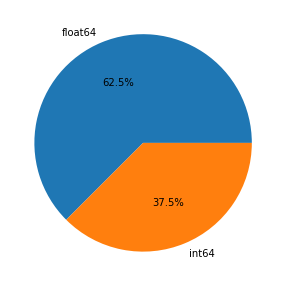

In [110]:
# Types des variables
get_types_variables(installm_paym, True, True, True)

In [213]:
def installments_payments(num_rows = None, nan_as_category = True):
    installm_paym = pd.read_csv('installments_payments.csv', nrows = num_rows)
    installm_paym, cat_cols = one_hot_encoder(installm_paym, nan_as_category= True)
   
    # Variables METIERS :
    # Percentage and difference paid in each installment (amount paid and installment value)
    installm_paym['PAYMENT_PERC'] = installm_paym['AMT_PAYMENT'] / installm_paym['AMT_INSTALMENT']
    installm_paym['PAYMENT_DIFF'] = installm_paym['AMT_INSTALMENT'] - installm_paym['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    installm_paym['DPD'] = installm_paym['DAYS_ENTRY_PAYMENT'] - installm_paym['DAYS_INSTALMENT']
    installm_paym['DBD'] = installm_paym['DAYS_INSTALMENT'] - installm_paym['DAYS_ENTRY_PAYMENT']
    installm_paym['DPD'] = installm_paym['DPD'].apply(lambda x: x if x > 0 else 0)
    installm_paym['DBD'] = installm_paym['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = installm_paym.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = installm_paym.groupby('SK_ID_CURR').size()
    del installm_paym
    gc.collect()
    return ins_agg

In [214]:
ins_agg = installments_payments(num_rows = None, nan_as_category = True)
ins_agg = ins_agg.reset_index()
ins_agg

SK_ID_CURR  INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
0           100001                                      2            11.0   
1           100002                                      2             0.0   
2           100003                                      2             0.0   
3           100004                                      2             0.0   
4           100005                                      2             1.0   
...            ...                                    ...             ...   
339582      456251                                      2             0.0   
339583      456252                                      1             3.0   
339584      456253                                      1             9.0   
339585      456254                                      1             0.0   
339586      456255                                      4             7.0   

        INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
0              1.571429            11.0            36.0         8.857143   
1              0.000000             0.0            31.0        20.421053   
2              0.000000             0.0            14.0         7.160000   
3              0.000000             0.0            11.0         7.666667   
4              0.111111             1.0            37.0        23.666667   
...                 ...             ...             ...              ...   
339582         0.000000             0.0            46.0        36.285714   
339583         0.500000             3.0            11.0         3.333333   
339584         0.642857             9.0            51.0        15.142857   
339585         0.000000             0.0            31.0        19.000000   
339586         0.702703            52.0            35.0         8.770270   

        INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
0                 62.0                  1.00000                  1.000000   
1                388.0                  1.00000                  1.000000   
2                179.0                  1.00000                  1.000000   
3                 23.0                  1.00000                  1.000000   
4                213.0                  1.00000                  1.000000   
...                ...                      ...                       ...   
339582           254.0                  1.00000                  1.000000   
339583            20.0                  1.00000                  1.000000   
339584           212.0                  1.00000                  0.928571   
339585           361.0                  1.00000                  1.000000   
339586           649.0                 12.38847                  1.033463   

        ...  INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM  \
0       ...                 5885.132143                  41195.925   
1       ...                11559.247105                 219625.695   
2       ...                64754.586000                1618864.650   
3       ...                 7096.155000                  21288.465   
4       ...                 6240.205000                  56161.845   
...     ...                         ...                        ...   
339582  ...                 7492.924286                  52450.470   
339583  ...                10069.867500                  60419.205   
339584  ...                 4399.707857                  61595.910   
339585  ...                10239.832895                 194556.825   
339586  ...                41464.713649                3068388.810   

        INSTAL_AMT_PAYMENT_MIN  INSTAL_AMT_PAYMENT_MAX  \
0                     3951.000               17397.900   
1                     9251.775               53093.745   
2                     6662.970              560835.360   
3                     5357.250               10573.965   
4                     4813.200               17656.245   
...                        ...                     ...  

In [113]:
# Valeurs manquantes du dataframe appl_train
df_nan_ins_agg = get_missing_values(ins_agg, True, False, True)

Valeurs manquantes : 2092 NaN pour 9168849 données (0.02 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



# Fusion avec train_cleaned et nettoyage variables fortement correlées

In [114]:
# jointure joint_3 (application_train_cleaned) et ins_agg
joint_4 = pd.merge(joint_3, ins_agg, how='left', on='SK_ID_CURR')
joint_4.shape

(307500, 480)

In [115]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_4 = suppr_var_colineaire(joint_4)

7 variables fortement corrélées à supprimer :

INSTAL_PAYMENT_PERC_SUM
INSTAL_PAYMENT_PERC_VAR
INSTAL_AMT_PAYMENT_MAX
INSTAL_AMT_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_SUM
INSTAL_DAYS_ENTRY_PAYMENT_MAX
INSTAL_COUNT


<ipython-input-74-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [117]:
# Suppression des variables fortement corrélées du joint_4
joint_4 = joint_4.drop(columns=var_corr_joint_4)
print(f'joint_4 : {joint_4.shape}')

joint_4 : (307500, 473)


In [118]:
# Valeurs manquantes du dataframe joint_4
df_nan_joint_4 = get_missing_values(joint_4, True, False, True)

Valeurs manquantes : 302159 NaN pour 145447500 données (0.21 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [119]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_4_median = joint_4.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_4_median}')
joint_4.fillna(joint_4.median(), inplace=True)
# Vérification
nb_nan_joint_4_median = joint_4.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_4_median}')

Nombre de nan avant imputation par median : 302159
Nombre de nan après imputation par median : 0


In [120]:
joint_4.shape

(307500, 473)

In [121]:
# Sauvegarde de joint_4 nettoyée, encodée, prête pour ML
joint_4.to_csv("joint_4_cleaned.csv", index=False)

In [41]:
joint_4=pd.read_csv("joint_4_cleaned.csv")

### <font color="#0000FF" id="section_1_7">1.7. Pré-processing "credit_card_balance.csv" + fusion</font>

**Présentation**

| Fichier | Description |
| --- | --- |
| <p style='text-align: justify;'>**credit_card_balance.csv** | <ul style='text-align: justify;'><li>Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit. </li> <li>  Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.</li></ul>|

In [49]:
# Valeurs manquantes du dataframe credit_card_balance 
df_nan_credit_card_balance = get_missing_values(credit_card_balance, True, False, True)

Valeurs manquantes : 5877356 NaN pour 88327176 données (6.65 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

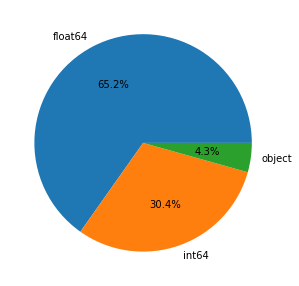

In [50]:
# Types des variables
get_types_variables(credit_card_balance, True, True, True)

In [220]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    credit_card_balance = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    credit_card_balance, cat_cols = one_hot_encoder(credit_card_balance, nan_as_category= True)
    # General aggregations
    credit_card_balance.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
    del credit_card_balance
    gc.collect()
    return cc_agg

In [221]:
cc_agg = credit_card_balance(num_rows = None, nan_as_category = True)
cc_agg = cc_agg.reset_index()
cc_agg

SK_ID_CURR  CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
0           100006                     -6                     -1   
1           100011                    -75                     -2   
2           100013                    -96                     -1   
3           100021                    -18                     -2   
4           100023                    -11                     -4   
...            ...                    ...                    ...   
103553      456244                    -41                     -1   
103554      456246                     -9                     -2   
103555      456247                    -96                     -2   
103556      456248                    -24                     -2   
103557      456250                    -12                     -1   

        CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  CC_MONTHS_BALANCE_VAR  \
0                         -3.5                    -21                    3.5   
1                        -38.5                  -2849                  462.5   
2                        -48.5                  -4656                  776.0   
3                        -10.0                   -170                   25.5   
4                         -7.5                    -60                    6.0   
...                        ...                    ...                    ...   
103553                   -21.0                   -861                  143.5   
103554                    -5.5                    -44                    6.0   
103555                   -49.0                  -4655                  760.0   
103556                   -13.0                   -299                   46.0   
103557                    -6.5                    -78                   13.0   

        CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  CC_AMT_BALANCE_MEAN  \
0                    0.000               0.000             0.000000   
1                    0.000          189000.000         54482.111149   
2                    0.000          161420.220         18159.919219   
3                    0.000               0.000             0.000000   
4                    0.000               0.000             0.000000   
...                    ...                 ...                  ...   
103553               0.000          453627.675        131834.730732   
103554               0.000           43490.115         13136.731875   
103555               0.000          190202.130         23216.396211   
103556               0.000               0.000             0.000000   
103557          153832.725          200208.915        173589.326250   

        CC_AMT_BALANCE_SUM  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                    0.000  ...                                   0   
1              4031676.225  ...                                   0   
2              1743352.245  ...                                   0   
3                    0.000  ...                                   0   
4                    0.000  ...                                   0   
...                    ...  ...                                 ...   
103553         5405223.960  ...                                   0   
103554          105093.855  ...                                   0   
103555         2205557.640  ...                                   0   
103556               0.000  ...                                   0   
103557         2083071.915  ...                                   0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
103553                                  0.0   
103554                                  0.0   
103555                                  0.0   
103556                                  0.0   
103557 

In [53]:
# Valeurs manquantes du dataframe credit_card_balance.csv
df_nan_cc_agg = get_missing_values(cc_agg, True, False, True)

Valeurs manquantes : 896550 NaN pour 14705236 données (6.1 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



# Fusion avec train_cleaned et nettoyage variables fortement correlées

In [54]:
# jointure joint_4 (application_train_cleaned) et cc_agg
joint_5 = pd.merge(joint_4, cc_agg, how='left', on='SK_ID_CURR')
joint_5.shape

(307500, 614)

In [57]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_5 = suppr_var_colineaire(joint_5)

72 variables fortement corrélées à supprimer :

CC_MONTHS_BALANCE_MIN
CC_MONTHS_BALANCE_MEAN
CC_MONTHS_BALANCE_SUM
CC_MONTHS_BALANCE_VAR
CC_AMT_BALANCE_MEAN
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
CC_AMT_DRAWINGS_CURRENT_MAX
CC_AMT_DRAWINGS_OTHER_CURRENT_SUM
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR
CC_AMT_DRAWINGS_POS_CURRENT_SUM
CC_AMT_INST_MIN_REGULARITY_MAX
CC_AMT_INST_MIN_REGULARITY_MEAN
CC_AMT_INST_MIN_REGULARITY_SUM
CC_AMT_INST_MIN_REGULARITY_VAR
CC_AMT_PAYMENT_CURRENT_MEAN
CC_AMT_PAYMENT_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN
CC_AMT_PAYMENT_TOTAL_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR
CC_AMT_RECEIVABLE_PRINCIPAL_MIN
CC_AMT_RECEIVABLE_PRINCIPAL_MAX
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN
CC_AMT_RECEIVABLE_PRINCIPAL_SUM
CC_AMT_RECEIVABLE_PRINCIPAL_VAR
CC_AMT_RECIVABLE_MIN
CC_AMT_RECIVABLE_MAX
CC_AMT_RECIVABLE_MEAN
CC_AMT_RECIVABLE_SUM
CC_AMT_RECIVABLE_VAR
CC_AMT_TOTAL_RECEIVABLE_MIN
CC_AMT_TOTAL_RECEIVABLE_MAX
CC_AMT_TOTAL_RECEIVABLE_MEAN
CC_AMT_TOTAL_RECEI

<ipython-input-56-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [130]:
# Suppression des variables fortement corrélées du joint_5
joint_5 = joint_5.drop(columns=var_corr_joint_5)
print(f'joint_5 : {joint_5.shape}')

joint_5 : (307500, 542)


In [131]:
# Valeurs manquantes du dataframe joint_5
df_nan_joint_5 = get_missing_values(joint_5, True, False, True)

Valeurs manquantes : 15767797 NaN pour 166665000 données (9.46 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [132]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_5_median = joint_5.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_5_median}')
joint_5.fillna(joint_5.median(), inplace=True)
# Vérification
nb_nan_joint_5_median = joint_5.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_5_median}')

Nombre de nan avant imputation par median : 15767797
Nombre de nan après imputation par median : 0


In [133]:
# TRES IMPORTANT : il y a un CARACTER SPECIAL dans le nom de colonne (importé par JSON) que le modele n'aime pas
# La CORRECTION est appliquée
import re
joint_5 = joint_5.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [134]:
joint_5.shape

(307500, 542)

In [136]:
# joint_5

In [137]:
# Sauvegarde de joint_5 nettoyée, encodée, prête pour ML
joint_5.to_csv("df_train_final.csv", index=False)

### Saved for work: "df_train_final.csv" ==> dataframe: df_train

In [138]:
df_train = pd.read_csv("df_train_final.csv")

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                            int64
TARGET                                int64
CODE_GENDER                           int64
FLAG_OWN_CAR                          int64
FLAG_OWN_REALTY                       int64
                                     ...   
CC_NAME_CONTRACT_STATUS_nan_MIN     float64
CC_NAME_CONTRACT_STATUS_nan_MAX     float64
CC_NAME_CONTRACT_STATUS_nan_MEAN    float64
CC_NAME_CONTRACT_STATUS_nan_SUM     float64
CC_NAME_CONTRACT_STATUS_nan_VAR     float64
Length: 542, dtype: object

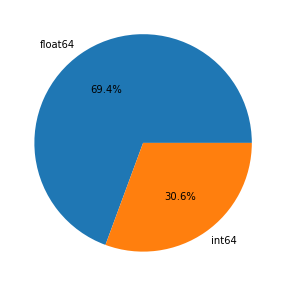

In [140]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(df_train, True, False, True)

In [141]:
df_train['TARGET'].value_counts()

0    282677
1     24823
Name: TARGET, dtype: int64

### <font color="#0000FF" id="section_1_8">1.8. Pré-processing "application_test" + fusion all dataframes</font>

In [165]:
def application_test_cleaned(num_rows = None, nan_as_category = False):
    # Read data 
    application_test = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}".format(len(application_test)))
    # Suppression de 4 clients avec sexe non renseigné, XNA CODE_GENDER (train set)
    application_test = application_test[application_test['CODE_GENDER'] != 'XNA']
    # Suppression de 5 clients  'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour 5 emprunters
    application_test = application_test[application_test['NAME_INCOME_TYPE'] != 'Maternity leave']
    # Suppression de 2 clients ayant  la colonne NAME_FAMILY_STATUS la valeur Unknown 
    application_test = application_test[application_test['NAME_FAMILY_STATUS'] != 'Unknown']
    
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        application_test[bin_feature], uniques = pd.factorize(application_test[bin_feature])
    # Categorical features with One-Hot encode
    application_test, cat_cols = one_hot_encoder(application_test, nan_as_category)
    
    # Correction valeurs aberantes: Nan pour DAYS_EMPLOYED: (18% lignes) 365243 (=1000 ans)-> nan
    application_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Nouvelles Features Engineering (percentages), variables métier, pour aider le modéle:
    # Le ratio temps travaillé/âge
    # Le ratio crédit/revenu
    # le ratio crédit/annuité/âge
    # le ratio revenu/annuité
    # le ratio crédit/annuité
    application_test['DAYS_EMPLOYED_PERC'] = application_test['DAYS_EMPLOYED'] / application_test['DAYS_BIRTH']
    application_test['INCOME_CREDIT_PERC'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_CREDIT']
    application_test['INCOME_PER_PERSON'] = application_test['AMT_INCOME_TOTAL'] / application_test['CNT_FAM_MEMBERS']
    application_test['ANNUITY_INCOME_PERC'] = application_test['AMT_ANNUITY'] / application_test['AMT_INCOME_TOTAL']
    application_test['PAYMENT_RATE'] = application_test['AMT_ANNUITY'] / application_test['AMT_CREDIT']
    # del test_df
    gc.collect()
    return application_test

In [172]:
appl_test_new = application_test_cleaned(num_rows = None, nan_as_category = False)
appl_test_new

Train samples: 48744


SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0          100001            0             0                0             0   
1          100005            1             0                0             0   
2          100013            1             1                0             0   
3          100028            0             0                0             2   
4          100038            1             1                1             1   
...           ...          ...           ...              ...           ...   
48739      456221            0             0                0             0   
48740      456222            0             0                1             2   
48741      456223            0             1                0             1   
48742      456224            1             0                1             0   
48743      456250            0             1                1             0   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0              135000.0    568800.0      20560.5         450000.0   
1               99000.0    222768.0      17370.0         180000.0   
2              202500.0    663264.0      69777.0         630000.0   
3              315000.0   1575000.0      49018.5        1575000.0   
4              180000.0    625500.0      32067.0         625500.0   
...                 ...         ...          ...              ...   
48739          121500.0    412560.0      17473.5         270000.0   
48740          157500.0    622413.0      31909.5         495000.0   
48741          202500.0    315000.0      33205.5         315000.0   
48742          225000.0    450000.0      25128.0         450000.0   
48743          135000.0    312768.0      24709.5         270000.0   

       REGION_POPULATION_RELATIVE  ...  WALLSMATERIAL_MODE_Panel  \
0                        0.018850  ...                         0   
1                        0.035792  ...                         0   
2                        0.019101  ...                         0   
3                        0.026392  ...                         1   
4                        0.010032  ...                         0   
...                           ...  ...                       ...   
48739                    0.002042  ...                         0   
48740                    0.035792  ...                         0   
48741                    0.026392  ...                         0   
48742                    0.018850  ...                         1   
48743                    0.006629  ...                         0   

       WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                    1                          0   
1                                    0                          0   
2                                    0                          0   
3                                    0                          0   
4                                    0                          0   
...                                ...                        ...   
48739                                0                          0   
48740                                0                          0   
48741                                1                          0   
48742                                0                          0   
48743                                0                          0   

       EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
0                           1                        0            0.121044   
1                           0                        0            0.247398   
2                           0                        0            0.222477   
3                           1                        0            0.133515   
4                           0                        0            0.168021   
...                       ...                      ...                 ...   
48739                       0        

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR               int64
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
CNT_CHILDREN             int64
                        ...   
DAYS_EMPLOYED_PERC     float64
INCOME_CREDIT_PERC     float64
INCOME_PER_PERSON      float64
ANNUITY_INCOME_PERC    float64
PAYMENT_RATE           float64
Length: 244, dtype: object

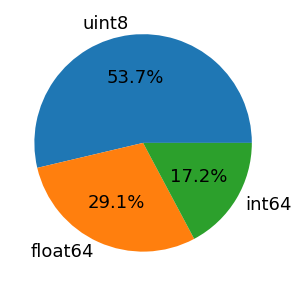

In [174]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(appl_test_new, True, False, True)

### Données manquantes

In [175]:
# Valeurs manquantes du dataframe appl_test_new
df_nan_appl_test = get_missing_values(appl_test_new, True, False, True)

Valeurs manquantes : 1303981 NaN pour 11893536 données (10.96 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [176]:
# Liste des variables ayant plus de 68% de valeurs manquantes
cols_nan_a_suppr = \
    df_nan_appl_test[df_nan_appl_test['% de valeurs manquantes'] > 68] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr)}')
cols_nan_a_suppr

Nombre de variables à supprimer : 6


['COMMONAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI']

In [177]:
# Suppression des variables avec un seuil de nan > 68%
appl_test_new.drop(columns=cols_nan_a_suppr, inplace=True)
# Taille : nombre de lignes/colonnes
nRow, nVar = appl_test_new.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 48744 lignes et 238 variables.


**Variables quantitatives /Imputation par median**

In [181]:
# Variables quantitatives
cols_num = appl_test_new.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num

['SK_ID_CURR',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MO

In [182]:
# Variables quantitatives - imputation par médiane
# Nous imputerons donc les valeurs manquantes des variables quantitatives par la valeur médiane 
# de chacune de ces variables puisque nous avons découvert lors de l'analyse exploratoire qu'il y avait de nombreux outliers
nb_nan_appl_test_median = appl_test_new[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_appl_test_median}')
appl_test_new.fillna(appl_test_new[cols_num].median(), inplace=True)
# Vérification
nb_nan_appl_test_median = appl_test_new[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_appl_test_median}')

Nombre de nan avant imputation par median : 1103455
Nombre de nan après imputation par median : 0


In [183]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr = appl_test_new.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

<ipython-input-183-3f8c92dcc847>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [184]:
# Variables avec un coef de Pearson > 0.8?
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

40 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
NAME_CONTRACT_TYPE_Revolving loans
NAME_INCOME_TYPE_Pensioner
NAME_EDUCATION_TYPE_Secondary / secondary special
ORGANIZATION_TYPE_XNA
EMERGENCYSTATE_MODE_No
DAYS_EMPLOYED_PERC


In [185]:
# Suppression des variables fortement corrélées
print(f'application_test_all : {appl_test_new.shape}')
appl_test_new.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_test_cleaned : {appl_test_new.shape}')

application_test_all : (48744, 238)
application_test_cleaned : (48744, 198)


In [186]:
# Sauvegarde de application_train nettoyée, encodée, prête pour ML
appl_test_new.to_csv("application_test_cleaned.csv", index=False)

In [187]:
appl_test_cleaned = pd.read_csv("application_test_cleaned.csv")

In [188]:
appl_test_cleaned

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0          100001            0             0                0             0   
1          100005            1             0                0             0   
2          100013            1             1                0             0   
3          100028            0             0                0             2   
4          100038            1             1                1             1   
...           ...          ...           ...              ...           ...   
48739      456221            0             0                0             0   
48740      456222            0             0                1             2   
48741      456223            0             1                0             1   
48742      456224            1             0                1             0   
48743      456250            0             1                1             0   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
0              135000.0    568800.0      20560.5                    0.018850   
1               99000.0    222768.0      17370.0                    0.035792   
2              202500.0    663264.0      69777.0                    0.019101   
3              315000.0   1575000.0      49018.5                    0.026392   
4              180000.0    625500.0      32067.0                    0.010032   
...                 ...         ...          ...                         ...   
48739          121500.0    412560.0      17473.5                    0.002042   
48740          157500.0    622413.0      31909.5                    0.035792   
48741          202500.0    315000.0      33205.5                    0.026392   
48742          225000.0    450000.0      25128.0                    0.018850   
48743          135000.0    312768.0      24709.5                    0.006629   

       DAYS_BIRTH  ...  WALLSMATERIAL_MODE_Monolithic  \
0          -19241  ...                              0   
1          -18064  ...                              0   
2          -20038  ...                              0   
3          -13976  ...                              0   
4          -13040  ...                              0   
...           ...  ...                            ...   
48739      -19970  ...                              0   
48740      -11186  ...                              0   
48741      -15922  ...                              0   
48742      -13968  ...                              0   
48743      -13962  ...                              0   

       WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                              0                         0   
1                              0                         0   
2                              0                         0   
3                              0                         1   
4                              0                         0   
...                          ...                       ...   
48739                          0                         0   
48740                          0                         0   
48741                          0                         0   
48742                          0                         1   
48743                          0                         0   

       WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                    1                          0   
1                                    0                          0   
2                                    0                          0   
3                                    0                          0   
4                                    0                          0   
...                                ...                        ...   
48739                                0                          0   
48740                                0                          0   
48741                                1        

## Fusion bureau_agg avec test_cleaned et nettoyage variables fortement correlées

In [193]:
# jointure appl_train (application_test_cleaned) et bureau_agg (bureau_and_balance)
joint_1 = pd.merge(appl_test_cleaned, bureau_agg, how='left', on='SK_ID_CURR')
joint_1.shape

(48744, 314)

In [194]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_1 = suppr_var_colineaire(joint_1)

40 variables fortement corrélées à supprimer :

BURO_AMT_CREDIT_SUM_SUM
BURO_AMT_CREDIT_SUM_DEBT_SUM
BURO_MONTHS_BALANCE_MIN_MIN
BURO_MONTHS_BALANCE_SIZE_MEAN
BURO_CREDIT_ACTIVE_Closed_MEAN
BURO_CREDIT_CURRENCY_currency 2_MEAN
BURO_CREDIT_TYPE_Credit card_MEAN
ACTIVE_DAYS_CREDIT_MAX
ACTIVE_DAYS_CREDIT_MEAN
ACTIVE_DAYS_CREDIT_ENDDATE_MAX
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN
ACTIVE_CREDIT_DAY_OVERDUE_MAX
ACTIVE_CREDIT_DAY_OVERDUE_MEAN
ACTIVE_AMT_CREDIT_SUM_MAX
ACTIVE_AMT_CREDIT_SUM_MEAN
ACTIVE_AMT_CREDIT_SUM_SUM
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN
ACTIVE_AMT_CREDIT_SUM_DEBT_SUM
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN
ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM
ACTIVE_AMT_ANNUITY_MEAN
ACTIVE_CNT_CREDIT_PROLONG_SUM
ACTIVE_MONTHS_BALANCE_MIN_MIN
ACTIVE_MONTHS_BALANCE_SIZE_MEAN
CLOSED_DAYS_CREDIT_MIN
CLOSED_DAYS_CREDIT_MEAN
CLOSED_DAYS_CREDIT_ENDDATE_MIN
CLOSED_DAYS_CREDIT_UPDATE_MEAN
CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN
CLOSED_AMT_CREDIT_SUM_MAX
CLOSED_AMT_CREDIT_SUM_MEAN
CLOSED_AMT_CREDIT

<ipython-input-192-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [195]:
# Suppression des variables fortement corrélées du joint_1
joint_1 = joint_1.drop(columns=var_corr_joint_1)
print(f'joint_1 : {joint_1.shape}')

joint_1 : (48744, 274)


In [196]:
# Valeurs manquantes du dataframe joint_1
df_nan_joint_1 = get_missing_values(joint_1, True, False, True)

Valeurs manquantes : 697231 NaN pour 13355856 données (5.22 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [197]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_1_median = joint_1.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_1_median}')
joint_1.fillna(joint_1.median(), inplace=True)
# Vérification
nb_nan_joint_1_median = joint_1.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_1_median}')

Nombre de nan avant imputation par median : 697231
Nombre de nan après imputation par median : 0


## Fusionprev_agg avec test_cleaned et nettoyage variables fortement correlées

In [200]:
# Fusion joint_1 (application_test_cleaned) et prev_agg 
joint_2 = pd.merge(joint_1, prev_agg, how='left', on='SK_ID_CURR')
joint_2.shape

(48744, 523)

In [201]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_2 = suppr_var_colineaire(joint_2)

78 variables fortement corrélées à supprimer :

PREV_AMT_ANNUITY_MEAN
PREV_AMT_CREDIT_MIN
PREV_AMT_CREDIT_MAX
PREV_AMT_CREDIT_MEAN
PREV_AMT_DOWN_PAYMENT_MEAN
PREV_AMT_GOODS_PRICE_MAX
PREV_AMT_GOODS_PRICE_MEAN
PREV_HOUR_APPR_PROCESS_START_MEAN
PREV_RATE_DOWN_PAYMENT_MEAN
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN
PREV_NAME_PAYMENT_TYPE_XNA_MEAN
PREV_CODE_REJECT_REASON_CLIENT_MEAN
PREV_CODE_REJECT_REASON_XAP_MEAN
PREV_NAME_CLIENT_TYPE_Repeater_MEAN
PREV_NAME_GOODS_CATEGORY_XNA_MEAN
PREV_NAME_PORTFOLIO_Cards_MEAN
PREV_NAME_PORTFOLIO_Cash_MEAN
PREV_NAME_PORTFOLIO_POS_MEAN
PREV_NAME_PORTFOLIO_XNA_MEAN
PREV_NAME_PRODUCT_TYPE_XNA_MEAN
PREV_CHANNEL_TYPE_Car dealer_MEAN
PREV_CHANNEL_TYPE_Credit and cash offices_MEAN
PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN
PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN
PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN
PREV_NAME_SELLER_INDUSTRY_XNA_MEAN
PREV_NAM

<ipython-input-192-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [202]:
# Suppression des variables fortement corrélées du joint_2
joint_2 = joint_2.drop(columns=var_corr_joint_2)
print(f'joint_2 : {joint_2.shape}')

joint_2 : (48744, 445)


In [203]:
# Valeurs manquantes du dataframe joint_2
df_nan_joint_2 = get_missing_values(joint_2, True, False, True)

Valeurs manquantes : 667176 NaN pour 21691080 données (3.08 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [204]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_2_median = joint_2.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_2_median}')
joint_2.fillna(joint_2.median(), inplace=True)
# Vérification
nb_nan_joint_2_median = joint_2.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_2_median}')

Nombre de nan avant imputation par median : 667176
Nombre de nan après imputation par median : 0


In [205]:
joint_2.shape

(48744, 445)

## Fusion pos_agg avec test_cleaned et nettoyage variables fortement correlées

In [208]:
# Fusion joint_2 (application_test_cleaned) et pos_agg
joint_3 = pd.merge(joint_2, pos_agg, how='left', on='SK_ID_CURR')
joint_3.shape

(48744, 463)

In [209]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_3 = suppr_var_colineaire(joint_3)

6 variables fortement corrélées à supprimer :

REFUSED_RATE_DOWN_PAYMENT_MAX
POS_MONTHS_BALANCE_MEAN
POS_SK_DPD_MEAN
POS_SK_DPD_DEF_MEAN
POS_NAME_CONTRACT_STATUS_Completed_MEAN
POS_COUNT


<ipython-input-192-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [210]:
# Suppression des variables fortement corrélées du joint_3
joint_3 = joint_3.drop(columns=var_corr_joint_3)
print(f'joint_3 : {joint_3.shape}')

joint_3 : (48744, 457)


In [211]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_3_median = joint_3.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_3_median}')
joint_3.fillna(joint_3.median(), inplace=True)
# Vérification
nb_nan_joint_3_median = joint_3.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_3_median}')

Nombre de nan avant imputation par median : 12168
Nombre de nan après imputation par median : 0


In [212]:
joint_3.shape

(48744, 457)

## Fusionins_agg avec test_cleaned et nettoyage variables fortement correlées

In [215]:
# jointure joint_3 (application_test_cleaned) et ins_agg
joint_4 = pd.merge(joint_3, ins_agg, how='left', on='SK_ID_CURR')
joint_4.shape

(48744, 483)

In [216]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_4 = suppr_var_colineaire(joint_4)

8 variables fortement corrélées à supprimer :

INSTAL_PAYMENT_PERC_MEAN
INSTAL_PAYMENT_PERC_SUM
INSTAL_PAYMENT_PERC_VAR
INSTAL_AMT_PAYMENT_MAX
INSTAL_AMT_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_SUM
INSTAL_DAYS_ENTRY_PAYMENT_MAX
INSTAL_COUNT


<ipython-input-192-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [217]:
# Suppression des variables fortement corrélées du joint_4
joint_4 = joint_4.drop(columns=var_corr_joint_4)
print(f'joint_4 : {joint_4.shape}')

joint_4 : (48744, 475)


In [218]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_4_median = joint_4.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_4_median}')
joint_4.fillna(joint_4.median(), inplace=True)
# Vérification
nb_nan_joint_4_median = joint_4.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_4_median}')

Nombre de nan avant imputation par median : 14686
Nombre de nan après imputation par median : 0


In [219]:
joint_4.shape

(48744, 475)

## Fusion cc_agg avec test_cleaned et nettoyage variables fortement correlées

In [222]:
# jointure joint_4 (application_test_cleaned) et cc_agg
joint_5 = pd.merge(joint_4, cc_agg, how='left', on='SK_ID_CURR')
joint_5.shape

(48744, 616)

In [223]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_5 = suppr_var_colineaire(joint_5)

73 variables fortement corrélées à supprimer :

CC_MONTHS_BALANCE_MIN
CC_MONTHS_BALANCE_MEAN
CC_MONTHS_BALANCE_SUM
CC_MONTHS_BALANCE_VAR
CC_AMT_BALANCE_MEAN
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
CC_AMT_DRAWINGS_CURRENT_MAX
CC_AMT_DRAWINGS_OTHER_CURRENT_SUM
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR
CC_AMT_DRAWINGS_POS_CURRENT_MEAN
CC_AMT_DRAWINGS_POS_CURRENT_SUM
CC_AMT_DRAWINGS_POS_CURRENT_VAR
CC_AMT_INST_MIN_REGULARITY_MAX
CC_AMT_INST_MIN_REGULARITY_MEAN
CC_AMT_INST_MIN_REGULARITY_SUM
CC_AMT_INST_MIN_REGULARITY_VAR
CC_AMT_PAYMENT_CURRENT_MIN
CC_AMT_PAYMENT_CURRENT_MEAN
CC_AMT_PAYMENT_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_MIN
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN
CC_AMT_PAYMENT_TOTAL_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR
CC_AMT_RECEIVABLE_PRINCIPAL_MIN
CC_AMT_RECEIVABLE_PRINCIPAL_MAX
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN
CC_AMT_RECEIVABLE_PRINCIPAL_SUM
CC_AMT_RECEIVABLE_PRINCIPAL_VAR
CC_AMT_RECIVABLE_MIN
CC_AMT_RECIVABLE_MAX
CC_AMT_RECIVABLE_MEAN
CC_AMT_RECIVABLE_SUM

<ipython-input-192-956c961c8cce>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [224]:
# Suppression des variables fortement corrélées du joint_5
joint_5 = joint_5.drop(columns=var_corr_joint_5)
print(f'joint_5 : {joint_5.shape}')

joint_5 : (48744, 543)


In [225]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_5_median = joint_5.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_5_median}')
joint_5.fillna(joint_5.median(), inplace=True)
# Vérification
nb_nan_joint_5_median = joint_5.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_5_median}')

Nombre de nan avant imputation par median : 2289219
Nombre de nan après imputation par median : 0


In [226]:
# TRES IMPORTANT : il y a un CARACTER SPECIAL dans le nom de colonne (importé par JSON) que le modele n'aime pas
# La CORRECTION est appliquée
import re
joint_5 = joint_5.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [227]:
joint_5.shape

(48744, 543)

In [228]:
# Sauvegarde de joint_5 nettoyée, encodée, prête pour ML
joint_5.to_csv("df_test_final.csv", index=False)

### Saved for work: "df_test_final.csv" ==> dataframe: df_test

In [230]:
df_test = pd.read_csv("df_test_final.csv")

## <font color="#0000FF" id="section_2">2. Features importance selection</font>

https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection/notebook

### <font color="#0000FF" id="section_2_1">2.1. Features selection : spécifiques à l'algorithme LIGHTGBM</font>

- Extrait du Kernel Kaggle : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importance déterminée par un modèle, Lightgbm dans notre cas.    

### Attention, rechargement du fichier plus loin 

In [58]:
df_train = pd.read_csv("df_train_final.csv")

In [59]:
df_train.shape

(307500, 542)

### Attention, je suis retourner sur le nettoyage car valeurs infini !

In [61]:
# Pour nettoyer les valeurs infini
df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_train = df_train.dropna()
df_train = df_train.reset_index()

In [65]:
df_train = df_train.drop(columns=['index'])

In [66]:
df_train

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1            0             0                0   
1           100003       0            1             0                1   
2           100004       0            0             1                0   
3           100006       0            1             0                0   
4           100007       0            0             0                0   
...            ...     ...          ...           ...              ...   
307476      456251       0            0             0                1   
307477      456252       0            1             0                0   
307478      456253       0            1             0                0   
307479      456254       1            1             0                0   
307480      456255       0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307476             0          157500.0    254700.0      27558.0   
307477             0           72000.0    269550.0      12001.5   
307478             0          153000.0    677664.0      29979.0   
307479             0          171000.0    370107.0      20205.0   
307480             0          157500.0    675000.0      49117.5   

        REGION_POPULATION_RELATIVE  ...  \
0                         0.018801  ...   
1                         0.003541  ...   
2                         0.010032  ...   
3                         0.008019  ...   
4                         0.028663  ...   
...                            ...  ...   
307476                    0.032561  ...   
307477                    0.025164  ...   
307478                    0.005002  ...   
307479                    0.005313  ...   
307480                    0.046220  ...   

        CC_NAME_CONTRACT_STATUS_Sentproposal_MAX  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
...                                          ...   
307476                                       0.0   
307477                                       0.0   
307478                                       0.0   
307479                                       0.0   
307480                                       0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MIN  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
307476                                 0.0   
307477                                 0.0   
307478                                 0.0   
307479                                 0.0   
307480                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
307476                                 0.0   
307477                                 0.0   
307478                                 0.0   
307479                                 0.0   
307480                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                  

-------------------------------------------------------------
Type de variable pour chacune des variables



index                                 int64
SK_ID_CURR                            int64
TARGET                                int64
CODE_GENDER                           int64
FLAG_OWN_CAR                          int64
                                     ...   
CC_NAME_CONTRACT_STATUS_nan_MIN     float64
CC_NAME_CONTRACT_STATUS_nan_MAX     float64
CC_NAME_CONTRACT_STATUS_nan_MEAN    float64
CC_NAME_CONTRACT_STATUS_nan_SUM     float64
CC_NAME_CONTRACT_STATUS_nan_VAR     float64
Length: 543, dtype: object

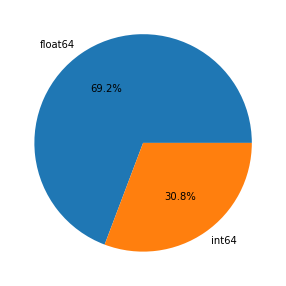

In [63]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(df_train, True, False, True)

### Re-Savuvegarde du fichier nettoyer des valeurs infinis: "df_train_final.csv" ==> dataframe: df_train

In [67]:
df_train.to_csv("df_train_final.csv", index=False)

### ICI: Reprise du rechargement du fichier pour features selection

In [4]:
df_train = pd.read_csv("df_train_final.csv")

In [5]:
df_train.shape

(307481, 542)

In [6]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       ...
       'CC_NAME_CONTRACT_STATUS_Sentproposal_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MIN',
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR'],
      dtype='object', length=542)

In [7]:
# Preparation X pour modéle: suppression variable 'TARGET'=Y et 
# Suppression des identifiants (variable non utile pour les variables pertinentes)
#X=df_train & del df_train['TARGET']
X = df_train.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
X.shape

(307481, 540)

In [8]:
Y = df_train['TARGET']
Y.shape

(307481,)

### Identification variables de ZERO importance

In [9]:
import lightgbm as lgb
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.2, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [10]:
zero_features, df_train_featimp_lightgbm = identify_zero_importance_features(X, Y)

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.781396	valid_0's binary_logloss: 0.509492


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.784922	valid_0's binary_logloss: 0.51266

There are 178 features with 0.0 importance


In [11]:
df_train_featimp_lightgbm.head()

feature  importance
194               PAYMENT_RATE       160.0
195  TARGET_NEIGHBORS_500_MEAN       145.0
8                   DAYS_BIRTH        98.0
290      PREV_CNT_PAYMENT_MEAN        85.0
9                DAYS_EMPLOYED        76.0

In [12]:
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

178 variables avec 0.0 importance :



['CC_AMT_DRAWINGS_ATM_CURRENT_MIN',
 'ORGANIZATION_TYPE_Industrytype4',
 'POS_NAME_CONTRACT_STATUS_Demand_MEAN',
 'ORGANIZATION_TYPE_Industrytype13',
 'ORGANIZATION_TYPE_Industrytype3',
 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'POS_NAME_CONTRACT_STATUS_XNA_MEAN',
 'POS_NAME_CONTRACT_STATUS_nan_MEAN',
 'OCCUPATION_TYPE_Cookingstaff',
 'ORGANIZATION_TYPE_Industrytype2',
 'OCCUPATION_TYPE_HRstaff',
 'OCCUPATION_TYPE_ITstaff',
 'OCCUPATION_TYPE_Managers',
 'ORGANIZATION_TYPE_Cleaning',
 'ORGANIZATION_TYPE_BusinessEntityType1',
 'ORGANIZATION_TYPE_Industrytype11',
 'OCCUPATION_TYPE_Realtyagents',
 'ORGANIZATION_TYPE_Industrytype10',
 'CC_MONTHS_BALANCE_MAX',
 'OCCUPATION_TYPE_Secretaries',
 'OCCUPATION_TYPE_Securitystaff',
 'ORGANIZATION_TYPE_Industrytype1',
 'ORGANIZATION_TYPE_Housing',
 'ORGANIZATION_TYPE_Emergency',
 'ORGANIZATION_TYPE_Electricity',
 'NAME_HOUSING_TYPE_Coopapartment',
 'ORGANIZATION_TYPE_Culture',
 'ORGANIZATION_TYPE_Advertising',
 'ORGANIZATION_TYPE_Agriculture',
 'O

In [13]:
# Suppression des variables avec zéro importance
X = X.drop(columns=zero_features)
print(f'X : {X.shape}')

X : (307481, 362)


***Second passage***

In [14]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_train_featimp_lightgbm_2 = identify_zero_importance_features(X, Y)

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.781234	valid_0's binary_logloss: 0.508814


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.785358	valid_0's binary_logloss: 0.512615

There are 0 features with 0.0 importance


## Au total: 362 Features importance LOCALE avec librairie specialisé du modéle LightGBM 

In [15]:
X.shape

(307481, 362)

In [16]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (First 50 Features)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

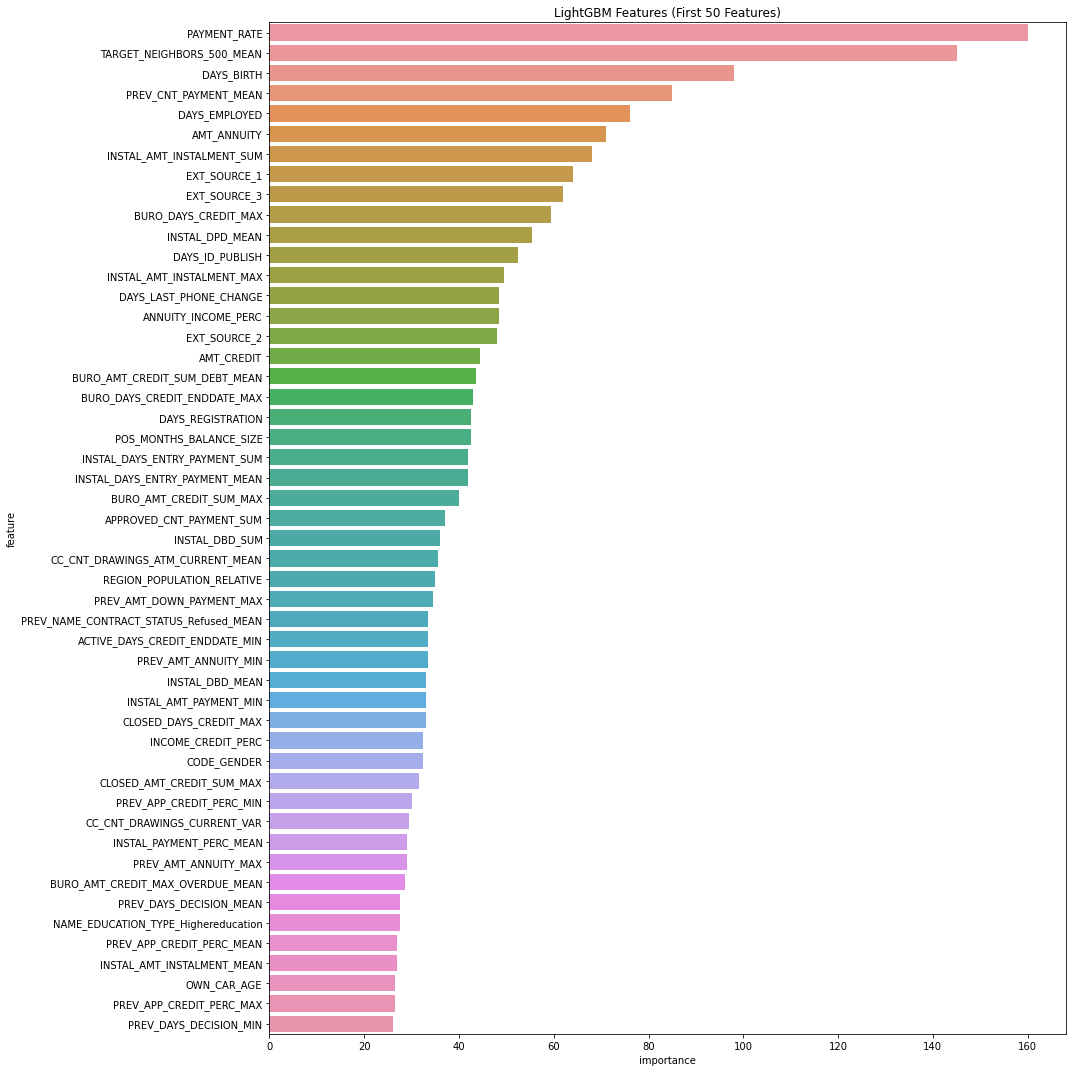

In [17]:
display_importances(df_train_featimp_lightgbm)

In [18]:
def plot_cumulative_feature_importances(df, threshold = 0.9):
    """
    Prints the number of features needed to reach threshold cumulative importance.
    Source : 
    https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
   
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Nombre de variables'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d variables nécessaires pour %0.2f de cumulative importance' % (importance_index + 1, threshold))
    
    return df

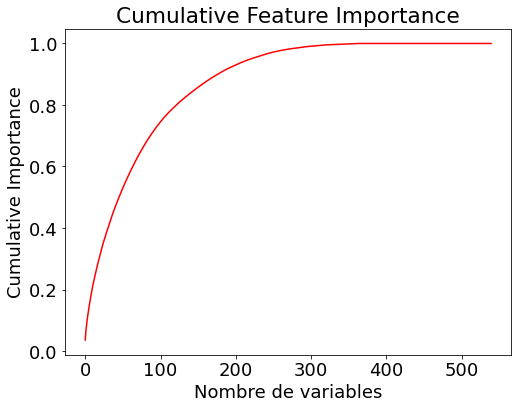

177 variables nécessaires pour 0.90 de cumulative importance


In [19]:
df_importance_features = plot_cumulative_feature_importances(df_train_featimp_lightgbm)

In [20]:
df_importance_features

index                                      feature  importance  \
0      194                                 PAYMENT_RATE       160.0   
1      195                    TARGET_NEIGHBORS_500_MEAN       145.0   
2        8                                   DAYS_BIRTH        98.0   
3      290                        PREV_CNT_PAYMENT_MEAN        85.0   
4        9                                DAYS_EMPLOYED        76.0   
..     ...                                          ...         ...   
535    444  POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN         0.0   
536    489            CC_AMT_DRAWINGS_OTHER_CURRENT_MIN         0.0   
537     74                 NAME_INCOME_TYPE_Businessman         0.0   
538     72                NAME_TYPE_SUITE_Spousepartner         0.0   
539    539              CC_NAME_CONTRACT_STATUS_nan_VAR         0.0   

     importance_normalized  cumulative_importance  
0                 0.035915               0.035915  
1                 0.032548               0.068462  
2                 0.021998               0.090460  
3                 0.019080               0.109540  
4                 0.017059               0.126599  
..                     ...                    ...  
535               0.000000               1.000000  
536               0.000000               1.000000  
537               0.000000               1.000000  
538               0.000000               1.000000  
539               0.000000               1.000000  

[540 rows x 5 columns]

In [21]:
df_features_selection = df_importance_features[df_importance_features['cumulative_importance'] <0.9]
df_features_selection

index                              feature  importance  \
0      194                         PAYMENT_RATE       160.0   
1      195            TARGET_NEIGHBORS_500_MEAN       145.0   
2        8                           DAYS_BIRTH        98.0   
3      290                PREV_CNT_PAYMENT_MEAN        85.0   
4        9                        DAYS_EMPLOYED        76.0   
..     ...                                  ...         ...   
171    498           CC_AMT_PAYMENT_CURRENT_MAX         6.5   
172    398         PREV_CHANNEL_TYPE_Stone_MEAN         6.5   
173    520  CC_NAME_CONTRACT_STATUS_Active_MEAN         6.5   
174     37             OBS_30_CNT_SOCIAL_CIRCLE         6.5   
175     98            OCCUPATION_TYPE_Corestaff         6.5   

     importance_normalized  cumulative_importance  
0                 0.035915               0.035915  
1                 0.032548               0.068462  
2                 0.021998               0.090460  
3                 0.019080               0.109540  
4                 0.017059               0.126599  
..                     ...                    ...  
171               0.001459               0.892817  
172               0.001459               0.894276  
173               0.001459               0.895735  
174               0.001459               0.897194  
175               0.001459               0.898653  

[176 rows x 5 columns]

## Selection liste de FEATURES_IMPORTANCE

In [22]:
features_selection_liste = list(df_features_selection['feature'])
len(features_selection_liste)

176

In [23]:
features_selection_liste

['PAYMENT_RATE',
 'TARGET_NEIGHBORS_500_MEAN',
 'DAYS_BIRTH',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'INSTAL_AMT_INSTALMENT_SUM',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'BURO_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_INSTALMENT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'ANNUITY_INCOME_PERC',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_REGISTRATION',
 'POS_MONTHS_BALANCE_SIZE',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'APPROVED_CNT_PAYMENT_SUM',
 'INSTAL_DBD_SUM',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REGION_POPULATION_RELATIVE',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'INSTAL_DBD_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'CODE_GENDER',
 'INCOME_CREDIT_PERC',
 'CLOSED_AMT_CREDIT_SUM_MAX',
 'PREV_APP_CREDIT_PERC_MIN',
 

In [24]:
len(X.columns)

362

In [25]:
liste1 = list(X.columns)
len(liste1)

362

In [26]:
df_train_featimp_lightgbm.head()

feature  importance
194               PAYMENT_RATE       160.0
195  TARGET_NEIGHBORS_500_MEAN       145.0
8                   DAYS_BIRTH        98.0
290      PREV_CNT_PAYMENT_MEAN        85.0
9                DAYS_EMPLOYED        76.0

### <font color="#0000FF" id="section_2_2">2.2. Features selection : globale SHAP avec permutation importance</font>

Cette procédure rompt la relation entre la caractéristique et la cible. La baisse du score du modèle indique donc à quel point le modèle dépend de la caractéristique. Cette technique a l'avantage d'être agnostique vis-à-vis du modèle et peut être calculée de nombreuses fois avec différentes permutations de la caractéristique.   L'importance de la permutation ne reflète pas la valeur prédictive intrinsèque d'une caractéristique en soi, mais l'importance de cette caractéristique pour un modèle particulier.

In [27]:
X_perm = df_train.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
X_perm.shape

(307481, 540)

In [28]:
Y_perm = df_train['TARGET']
Y_perm.shape

(307481,)

In [29]:
# Split into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_perm, Y_perm, test_size=0.2, random_state=42)

In [30]:
# Create the model with several hyperparameters
lgbm = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

# Train using early stopping
lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test, y_test)], eval_metric = 'auc', verbose = 200)

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.779456	valid_0's binary_logloss: 0.512542


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               n_estimators=10000, objective='binary')

In [31]:
# -- PLOT LES SHAP VALUES AVEC SKLEARN - GLOBALE
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, x_test, y_test, figsize=(6, 6)):
    '''
    Affiche les SHAPE VALUES.
    Parameters
    ----------
    model: le modèle de machine learning, obligatoire
    x_test :le jeu de test de la matrice X, obligatoire
    y_test :le jeu de test de la target, obligatoire
    Returns
    -------
    perm_importance : permutation importance
    '''
    perm_importance = permutation_importance(model, x_test, y_test)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.figure(figsize=figsize)
    plt.barh(x_test.columns[sorted_idx],
             perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance (%)")
    plt.show()    
    
    return perm_importance 

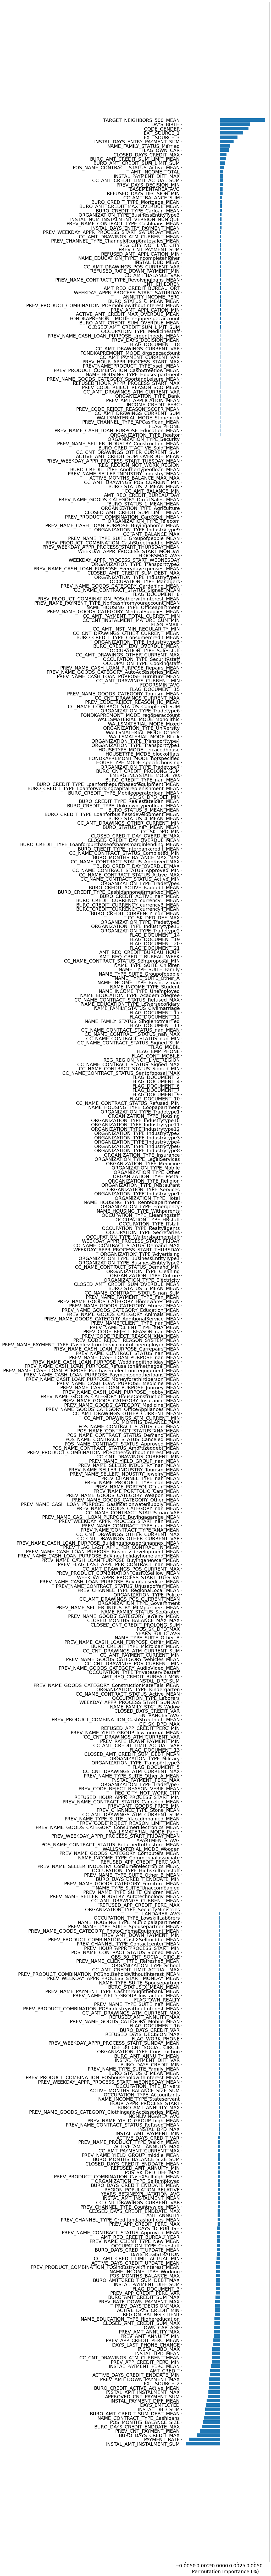

In [32]:
# Feature importance par permutation importance avec sklearn
perm_imp_sklearn = plot_permutation_importance(lgbm, X_test, y_test, figsize=(6, 180))

In [34]:
# Constitution du dataframe de travail
df_perm_imp_sklearn = pd.DataFrame({'feature': X_test.columns,
                  'Importance_perm': perm_imp_sklearn.importances_mean,
                  'Importance_abs_perm': np.abs(perm_imp_sklearn.importances_mean)})
df_perm_imp_sklearn.head()

feature  Importance_perm  Importance_abs_perm
0       CODE_GENDER         0.004095             0.004095
1      FLAG_OWN_CAR         0.001275             0.001275
2   FLAG_OWN_REALTY        -0.000124             0.000124
3      CNT_CHILDREN         0.000124             0.000124
4  AMT_INCOME_TOTAL         0.000462             0.000462

In [35]:
# Selection Variables/Features sans zéros importances
features_perm_imp_sklearn = df_perm_imp_sklearn[df_perm_imp_sklearn['Importance_abs_perm'] != 0.000]
print(f'{features_perm_imp_sklearn.shape[0]} variables sans zéro importance')

340 variables sans zéro importance


In [36]:
features_perm_imp_sklearn

feature  Importance_perm  Importance_abs_perm
0                            CODE_GENDER         0.004095             0.004095
1                           FLAG_OWN_CAR         0.001275             0.001275
2                        FLAG_OWN_REALTY        -0.000124             0.000124
3                           CNT_CHILDREN         0.000124             0.000124
4                       AMT_INCOME_TOTAL         0.000462             0.000462
..                                   ...              ...                  ...
512      CC_CNT_DRAWINGS_POS_CURRENT_MIN        -0.000016             0.000016
513     CC_CNT_INSTALMENT_MATURE_CUM_MIN         0.000010             0.000010
515                        CC_SK_DPD_MAX        -0.000029             0.000029
520  CC_NAME_CONTRACT_STATUS_Active_MEAN        -0.000026             0.000026
533  CC_NAME_CONTRACT_STATUS_Signed_MEAN         0.000013             0.000013

[340 rows x 3 columns]

In [37]:
# Display/plot feature importance
def display_importances_feature_permutation(feature_importance_df_):
    cols = feature_importance_df_[["feature", "Importance_abs_perm"]].groupby("feature").mean().sort_values(by="Importance_abs_perm", ascending=False)[:50].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 15))
    sns.barplot(x="Importance_abs_perm", y="feature", data=best_features.sort_values(by="Importance_abs_perm", ascending=False))
    plt.title('Feature permutation_importance selection (First 50 Features)')
    plt.tight_layout()
    plt.savefig('lgbm_importances_perm01.png')

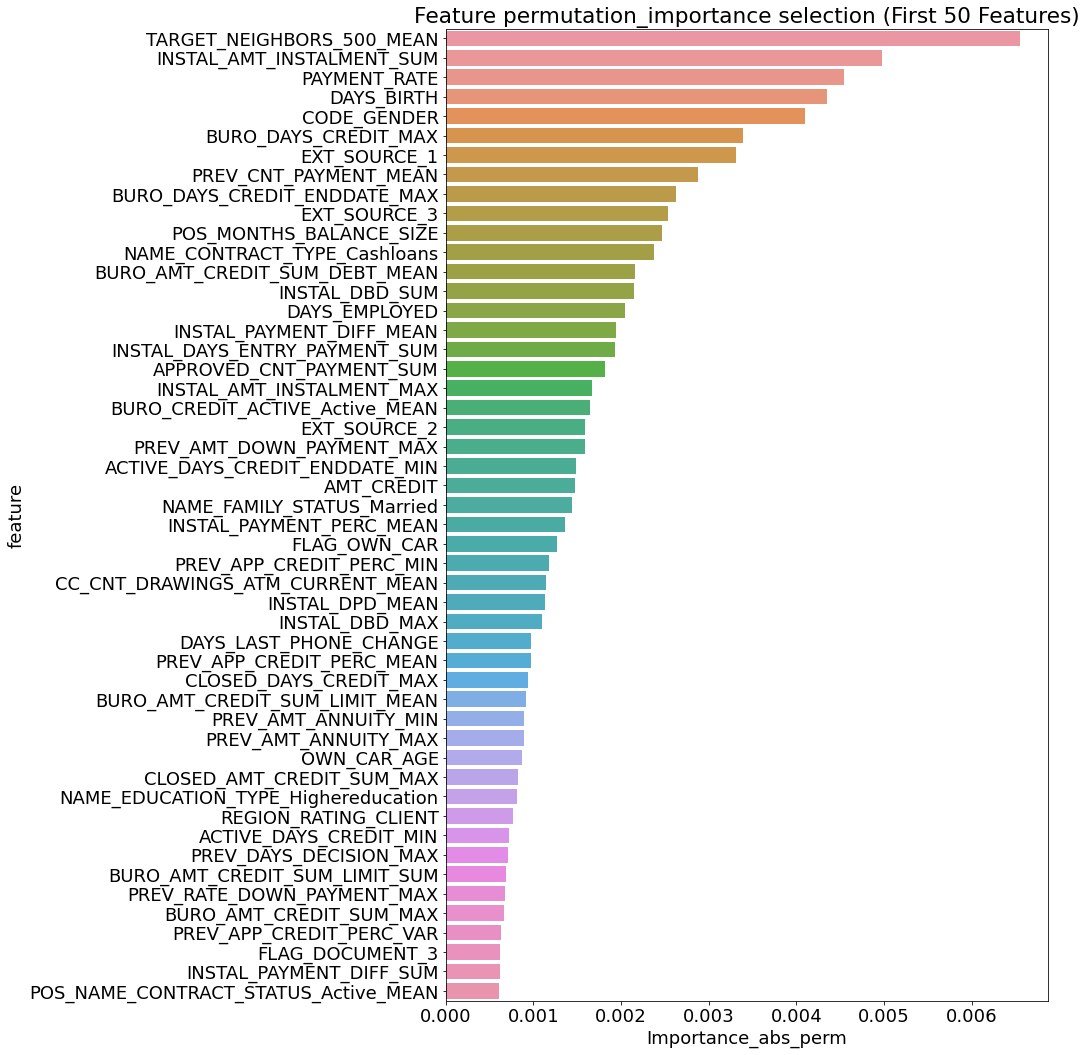

In [38]:
display_importances_feature_permutation(features_perm_imp_sklearn)

###  Au total: 342 Features importance avec GLOBAL - SKLEAN / Feature permutation

In [39]:
liste2 = list(features_perm_imp_sklearn['feature'])
len(liste2)

340

In [40]:
liste_commune = liste1 and liste2
len(liste_commune)

340

### <font color="#0000FF" id="section_2_3">2.3. Selection finale features pour modélisation</font>

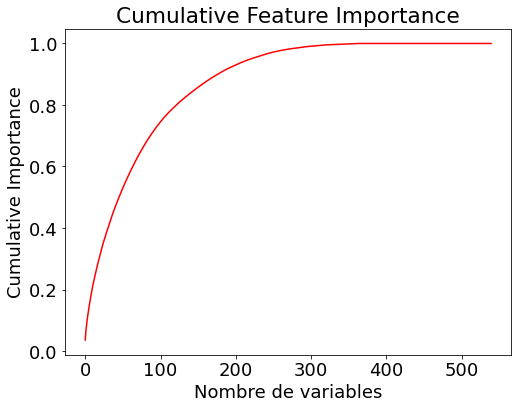

177 variables nécessaires pour 0.90 de cumulative importance


In [41]:
df_importance_features = plot_cumulative_feature_importances(df_train_featimp_lightgbm)

In [46]:
# seuil pour selectionner le nombre maximum des variables
# seuil = 0.9 ==> 176 variables selectionnées 
df_features_selection = df_importance_features[df_importance_features['cumulative_importance'] <0.9]
df_features_selection

index                              feature  importance  \
0      194                         PAYMENT_RATE       160.0   
1      195            TARGET_NEIGHBORS_500_MEAN       145.0   
2        8                           DAYS_BIRTH        98.0   
3      290                PREV_CNT_PAYMENT_MEAN        85.0   
4        9                        DAYS_EMPLOYED        76.0   
..     ...                                  ...         ...   
171    498           CC_AMT_PAYMENT_CURRENT_MAX         6.5   
172    398         PREV_CHANNEL_TYPE_Stone_MEAN         6.5   
173    520  CC_NAME_CONTRACT_STATUS_Active_MEAN         6.5   
174     37             OBS_30_CNT_SOCIAL_CIRCLE         6.5   
175     98            OCCUPATION_TYPE_Corestaff         6.5   

     importance_normalized  cumulative_importance  
0                 0.035915               0.035915  
1                 0.032548               0.068462  
2                 0.021998               0.090460  
3                 0.019080               0.109540  
4                 0.017059               0.126599  
..                     ...                    ...  
171               0.001459               0.892817  
172               0.001459               0.894276  
173               0.001459               0.895735  
174               0.001459               0.897194  
175               0.001459               0.898653  

[176 rows x 5 columns]

In [47]:
features_selection_liste = list(df_features_selection['feature'])
len(features_selection_liste)

176

In [48]:
features_selection_liste

['PAYMENT_RATE',
 'TARGET_NEIGHBORS_500_MEAN',
 'DAYS_BIRTH',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'INSTAL_AMT_INSTALMENT_SUM',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'BURO_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_INSTALMENT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'ANNUITY_INCOME_PERC',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_REGISTRATION',
 'POS_MONTHS_BALANCE_SIZE',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'APPROVED_CNT_PAYMENT_SUM',
 'INSTAL_DBD_SUM',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REGION_POPULATION_RELATIVE',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'INSTAL_DBD_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'CODE_GENDER',
 'INCOME_CREDIT_PERC',
 'CLOSED_AMT_CREDIT_SUM_MAX',
 'PREV_APP_CREDIT_PERC_MIN',
 

In [49]:
features_selection_liste.remove('TARGET_NEIGHBORS_500_MEAN')

In [50]:
features_selection_liste.remove('INSTAL_PAYMENT_PERC_MEAN')
features_selection_liste.remove('CLOSED_AMT_CREDIT_SUM_MAX')
features_selection_liste.remove('PREV_CHANNEL_TYPE_Creditandcashoffices_MEAN')

In [51]:
len(features_selection_liste)

172

## Sauvegarde de features selection (172 var pour corr < 0.9)

In [52]:
# Sauvegarde des variables conservées pour le train_set et test_set
fic_var_features_172 = 'features_172.pickle'
with open(fic_var_features_172, 'wb') as f:
    pickle.dump(features_selection_liste, f, pickle.HIGHEST_PROTOCOL)

In [57]:
# Chargement des variables conservées pour le train_set et test_set
fic_var_features_172 = 'features_172.pickle'
with open('features_172.pickle', 'rb') as fic_var_features_172:
    features_selection_liste_172 = pickle.load(fic_var_features_172)
len(features_selection_liste_172)

172

## Constitution du dataframe pour entrainement sur train_set

In [58]:
features_selection_liste_172.insert(0, 'TARGET')
features_selection_liste_172.insert(0, 'SK_ID_CURR')
print(len(features_selection_liste_172))
features_selection_liste_172

174


['SK_ID_CURR',
 'TARGET',
 'PAYMENT_RATE',
 'DAYS_BIRTH',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'INSTAL_AMT_INSTALMENT_SUM',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'BURO_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_INSTALMENT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'ANNUITY_INCOME_PERC',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_REGISTRATION',
 'POS_MONTHS_BALANCE_SIZE',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'APPROVED_CNT_PAYMENT_SUM',
 'INSTAL_DBD_SUM',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REGION_POPULATION_RELATIVE',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'INSTAL_DBD_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'CODE_GENDER',
 'INCOME_CREDIT_PERC',
 'PREV_APP_CREDIT_PERC_MIN',
 'CC_CNT_DRAWINGS_CURRENT_VAR',
 'P

In [61]:
df_appl_train = df_train[features_selection_liste_172]

In [62]:
df_appl_train

SK_ID_CURR  TARGET  PAYMENT_RATE  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  \
0           100002       1      0.060749       -9461              24.000000   
1           100003       0      0.027598      -16765              10.000000   
2           100004       0      0.050000      -19046               4.000000   
3           100006       0      0.094941      -19005              23.000000   
4           100007       0      0.042623      -19932              20.666667   
...            ...     ...           ...         ...                    ...   
307476      456251       0      0.108198       -9327               8.000000   
307477      456252       0      0.044524      -20775               6.000000   
307478      456253       0      0.044239      -14966               5.000000   
307479      456254       1      0.054592      -11961              15.000000   
307480      456255       0      0.072767      -16856              21.750000   

        DAYS_EMPLOYED  AMT_ANNUITY  INSTAL_AMT_INSTALMENT_SUM  EXT_SOURCE_1  \
0              -637.0      24700.5                 219625.695      0.083037   
1             -1188.0      35698.5                1618864.650      0.311267   
2              -225.0       6750.0                  21288.465      0.505994   
3             -3039.0      29686.5                1007153.415      0.505994   
4             -3038.0      21865.5                 835985.340      0.505994   
...               ...          ...                        ...           ...   
307476         -236.0      27558.0                  52450.470      0.145570   
307477        -1648.0      12001.5                  60419.205      0.505994   
307478        -7921.0      29979.0                  61595.910      0.744026   
307479        -4786.0      20205.0                 194556.825      0.505994   
307480        -1262.0      49117.5                3068388.810      0.734460   

        EXT_SOURCE_3  ...  NAME_INCOME_TYPE_Working  \
0           0.139376  ...                         1   
1           0.535276  ...                         0   
2           0.729567  ...                         1   
3           0.535276  ...                         1   
4           0.535276  ...                         1   
...              ...  ...                       ...   
307476      0.535276  ...                         1   
307477      0.535276  ...                         0   
307478      0.218859  ...                         1   
307479      0.661024  ...                         0   
307480      0.113922  ...                         0   

        PREV_NAME_GOODS_CATEGORY_Computers_MEAN  \
0                                         0.000   
1                                         0.000   
2                                         0.000   
3                                         0.000   
4                                         0.000   
...                                         ...   
307476                                    0.000   
307477                                    0.000   
307478                                    0.000   
307479                                    0.500   
307480                                    0.125   

        PREV_CODE_REJECT_REASON_SCO_MEAN  PREV_HOUR_APPR_PROCESS_START_MIN  \
0                                    0.0                               9.0   
1                                    0.0                              12.0   
2                                    0.0                               5.0   
3                                    0.0                              12.0   
4                                    0.0                               8.0   
...                                  ...                               ...   
307476                               0.0                              17.0   
307477                               0.0                              10.0   
307478                               0.0                              11.0   
307479                               0.0                

In [63]:
df_appl_train.shape

(307481, 174)

###  Save final file with 172 important features (avec 0.9 cumulative importance) selection for work modeling
## "df_appl_train_imp_features_172.csv" ==> dataframe: df

In [65]:
# Sauvegarde de df_appl_train avec 178 important features pour ML modéling
df_appl_train.to_csv("df_appl_train_imp_features_172.csv", index=False)

## <font color="#0000FF" id="section_3">3. Simulation des modéles ML</font>

## lecture du dataframe issue du pre-processing (avec 172 variables de feature importance)

In [66]:
# read "df_appl_train_imp_features.csv" 
df = pd.read_csv("df_appl_train_imp_features_172.csv")
df.shape

(307481, 174)

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                               int64
TARGET                                   int64
PAYMENT_RATE                           float64
DAYS_BIRTH                               int64
PREV_CNT_PAYMENT_MEAN                  float64
                                        ...   
CC_AMT_PAYMENT_CURRENT_MAX             float64
PREV_CHANNEL_TYPE_Stone_MEAN           float64
CC_NAME_CONTRACT_STATUS_Active_MEAN    float64
OBS_30_CNT_SOCIAL_CIRCLE               float64
OCCUPATION_TYPE_Corestaff                int64
Length: 174, dtype: object

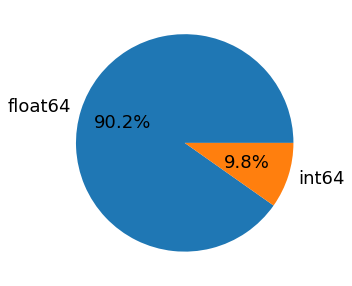

In [71]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(df, True, False, True)

In [72]:
X = df.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
X.shape

(307481, 172)

In [73]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled

In [74]:
Y = df['TARGET']
Y.shape

(307481,)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state = 42)

In [76]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
xgb.set_config(verbosity=0)
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold,cross_val_score, GridSearchCV

In [77]:
# Déclaration des algorithmes/modèles que je souhaite utiliser
# Choix des modèles avec les hyperparamètres de base pour choisir le meilleur modèle à optimiser

pipelines = {'Dummy Classifier': DummyClassifier(),
             'Logistic Regression': LogisticRegression(),
             'Random Forest': RandomForestClassifier(n_estimators=100),
             'GBM' : GradientBoostingClassifier(),
             'XGBoost' : XGBClassifier(),
             'LGBM': LGBMClassifier(),
             'KNN' : KNeighborsClassifier()}
n_splits = 5

In [78]:
from sklearn.model_selection import cross_validate

print('\033[1m'+ "Score moyen sur les", n_splits, "folds et Temps de traitement, pour les modèles suivants: ") 

for name, mo in pipelines.items():
    model = make_pipeline(mo)
    kfold = KFold(n_splits=n_splits)
    cross_validation_results = cross_val_score(model, X_train, y_train, scoring='roc_auc')
    scores = cross_validate(model, X_train, y_train, scoring='roc_auc')
    print('\033[0m', name, ": auc_score % 0.2f" % cross_validation_results.mean())
    print('\033[0m', mo, ": % 0.4f" % scores['fit_time'].mean(), "sec")

Score moyen sur les 5 folds et Temps de traitement, pour les modèles suivants: 
 Dummy Classifier : auc_score  0.50
 DummyClassifier() :  0.0858 sec
 Logistic Regression : auc_score  0.77
 LogisticRegression() :  4.2099 sec
 Random Forest : auc_score  0.73
 RandomForestClassifier() :  157.1312 sec
 GBM : auc_score  0.77
 GradientBoostingClassifier() :  434.9130 sec


C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: Th

 XGBoost : auc_score  0.77
 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None) :  35.8165 sec
 LGBM : auc_score  0.78
 LGBMClassifier() :  5.8761 sec
 KNN : auc_score  0.59
 KNeighborsClassifier() :  0.1558 sec


In [80]:
auc_score = [0.5, 0.77, 0.73, 0.77, 0.77, 0.78, 0.59]

In [81]:
Modele = ['DummyCls', 'LogisticRegression', 'RandomForest', 'GBM', 'XGBoost', 'LGBM', 'KNN']

In [82]:
Temps_traitm = [0.0822, 4.209, 157.13, 434.91, 35.816, 5.876, 0.1558]

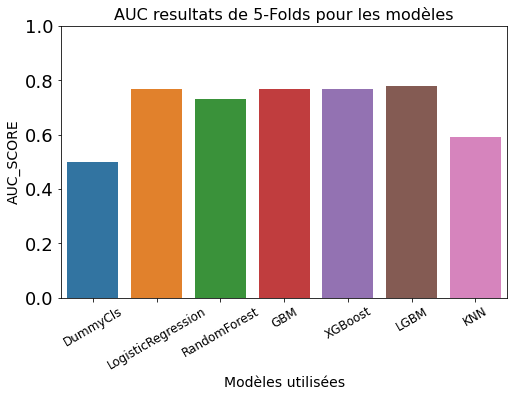

In [83]:
rcParams['figure.figsize'] = 8, 5
sns.barplot(x=Modele, y=auc_score)
plt.title("AUC resultats de 5-Folds pour les modèles", fontsize=16)
plt.xlabel("Modèles utilisées", fontsize=14)
plt.xticks([0,1,2,3,4,5,6],['DummyCls', 'LogisticRegression', 'RandomForest', 
                      'GBM', 'XGBoost', 'LGBM', 'KNN'], fontsize=12)
plt.xticks(rotation=30);
plt.ylim (0, 1)
plt.ylabel("AUC_SCORE", fontsize=14)
plt.show()

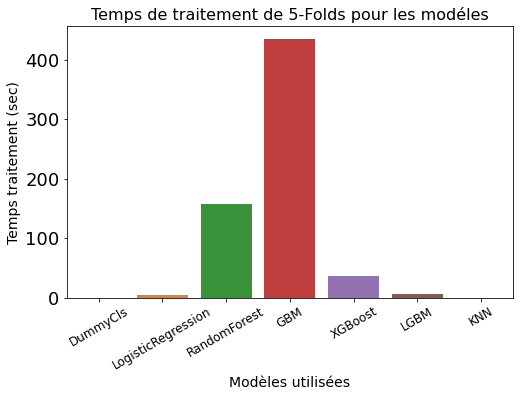

In [84]:
rcParams['figure.figsize'] = 8, 5
sns.barplot(x=Modele, y=Temps_traitm)
plt.title("Temps de traitement de 5-Folds pour les modéles", fontsize=16)
plt.xlabel("Modèles utilisées", fontsize=14)
plt.xticks([0,1,2,3,4,5,6],['DummyCls', 'LogisticRegression', 'RandomForest', 
                      'GBM', 'XGBoost', 'LGBM', 'KNN'], fontsize=12)
plt.xticks(rotation=30);
plt.ylabel("Temps traitement (sec)", fontsize=14)
plt.show()

## selection du meilleur modèle: LGBMClassifier 

In [85]:
best_model_lgbm = make_pipeline(LGBMClassifier())

In [86]:
# get_params() == Retourne les paramètres donnés dans le constructeur RandomForestRegressor()
# ainsi que les estimateurs contenus dans les étapes de la Pipeline.

best_model_lgbm.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'lgbmclassifier', 'lgbmclassifier__boosting_type', 'lgbmclassifier__class_weight', 'lgbmclassifier__colsample_bytree', 'lgbmclassifier__importance_type', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_depth', 'lgbmclassifier__min_child_samples', 'lgbmclassifier__min_child_weight', 'lgbmclassifier__min_split_gain', 'lgbmclassifier__n_estimators', 'lgbmclassifier__n_jobs', 'lgbmclassifier__num_leaves', 'lgbmclassifier__objective', 'lgbmclassifier__random_state', 'lgbmclassifier__reg_alpha', 'lgbmclassifier__reg_lambda', 'lgbmclassifier__silent', 'lgbmclassifier__subsample', 'lgbmclassifier__subsample_for_bin', 'lgbmclassifier__subsample_freq'])

In [87]:
params_model_lgbm = best_model_lgbm.get_params()
params_model_lgbm

{'memory': None,
 'steps': [('lgbmclassifier', LGBMClassifier())],
 'verbose': False,
 'lgbmclassifier': LGBMClassifier(),
 'lgbmclassifier__boosting_type': 'gbdt',
 'lgbmclassifier__class_weight': None,
 'lgbmclassifier__colsample_bytree': 1.0,
 'lgbmclassifier__importance_type': 'split',
 'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': -1,
 'lgbmclassifier__min_child_samples': 20,
 'lgbmclassifier__min_child_weight': 0.001,
 'lgbmclassifier__min_split_gain': 0.0,
 'lgbmclassifier__n_estimators': 100,
 'lgbmclassifier__n_jobs': -1,
 'lgbmclassifier__num_leaves': 31,
 'lgbmclassifier__objective': None,
 'lgbmclassifier__random_state': None,
 'lgbmclassifier__reg_alpha': 0.0,
 'lgbmclassifier__reg_lambda': 0.0,
 'lgbmclassifier__silent': 'warn',
 'lgbmclassifier__subsample': 1.0,
 'lgbmclassifier__subsample_for_bin': 200000,
 'lgbmclassifier__subsample_freq': 0}

In [88]:
# sauvegarde du best_model_lgbm
filename_params_model = 'params_model_lgbm.md'
# Sauvegarde du modèle
pickle.dump(params_model_lgbm, open(filename_params_model, 'wb'))

In [89]:
with open('params_model_lgbm.md',"rb") as filename_params_model:
    params_model_lgbm=pickle.load(filename_params_model) 

In [98]:
# params_model_lgbm

## Model optimization using randomized cross-validation

 - Different gradient boosting models were tested (scikit-learn one, XGBoost, LightGBM)
 - Only LightGBM provided with sufficient low CPU times
 - Using Random CV rather than Grid CV due to the large number of hyperparams
 - CV using 5 stratified folds

### unbalanced data ==> traitement par ajustement des poids des classes: scale_pos_weight=weight pour binary classification

In [90]:
df_pay = df[df.TARGET == 0]
df_unpay = df[df.TARGET == 1]

In [91]:
df.TARGET.value_counts()

0    282660
1     24821
Name: TARGET, dtype: int64

In [92]:
len(df_pay)/len(df_unpay)

11.387937633455541

In [93]:
len(df_pay)

282660

In [94]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

n = 25
weight = len(df_pay)/len(df_unpay)

lgbm = LGBMClassifier(max_depth=-1,
                      random_state=13,
                      silent=True,
                      metric='None',
                      n_jobs=-1,
                      n_estimators=200,
                      scale_pos_weight=weight,
                      )

lgbm_param = {'num_leaves': np.linspace(10, 80, 7, dtype='int'),
              'min_child_samples': (5, 10, 30, 40),
              'min_child_weight': [1e-3, 1e-2, 1, 1e2, 1e3],
              'subsample': (0.2, 0.8),
              'colsample_bytree': (0.3, 0.4, 0.5),
              'reg_alpha': [0.1, 1,  10, 100],
              'reg_lambda': [0.1, 1, 10,  50, 100]}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train, y_train)

print(round(grid.best_score_, 5))
print(grid.best_params_)
optima = pd.DataFrame(grid.cv_results_).T
optima

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


0.78642
{'subsample': 0.2, 'reg_lambda': 50, 'reg_alpha': 10, 'num_leaves': 33, 'min_child_weight': 1000.0, 'min_child_samples': 30, 'colsample_bytree': 0.3}


0   \
mean_fit_time                                                    42.234885   
std_fit_time                                                      3.893891   
mean_score_time                                                   1.178446   
std_score_time                                                    0.028813   
param_subsample                                                        0.2   
param_reg_lambda                                                       100   
param_reg_alpha                                                          1   
param_num_leaves                                                        21   
param_min_child_weight                                                0.01   
param_min_child_samples                                                  5   
param_colsample_bytree                                                 0.3   
params                   {'subsample': 0.2, 'reg_lambda': 100, 'reg_alp...   
split0_test_score                                                  0.78285   
split1_test_score                                                 0.784865   
split2_test_score                                                 0.785038   
split3_test_score                                                 0.786693   
split4_test_score                                                 0.789212   
mean_test_score                                                   0.785732   
std_test_score                                                    0.002125   
rank_test_score                                                          4   

                                                                        1   \
mean_fit_time                                                    63.465059   
std_fit_time                                                      0.859585   
mean_score_time                                                   1.657164   
std_score_time                                                    0.091438   
param_subsample                                                        0.2   
param_reg_lambda                                                         1   
param_reg_alpha                                                        100   
param_num_leaves                                                        68   
param_min_child_weight                                                0.01   
param_min_child_samples                                                 30   
param_colsample_bytree                                                 0.5   
params                   {'subsample': 0.2, 'reg_lambda': 1, 'reg_alpha...   
split0_test_score                                                 0.781387   
split1_test_score                                                 0.783589   
split2_test_score                                                 0.783245   
split3_test_score                                                 0.785791   
split4_test_score                                                 0.786038   
mean_test_score                                                    0.78401   
std_test_score                                                    0.001728   
rank_test_score                                                         18   

                                                                        2   \
mean_fit_time                                                    41.348699   
std_fit_time                                                      2.732747   
mean_score_time                                                   1.202781   
std_score_time                                                    0.056762   
param_subsample                                                        0.2   
param_reg_lambda                                                        10   
param_reg_alpha                                                        100   
param_num_leaves                                                        21   
param_min_child_weight                                               0.001   
param_min_chil

In [95]:
print(round(grid.best_score_, 5))

0.78642


In [96]:
lgbm_best_params = grid.best_params_
lgbm_best_params

{'subsample': 0.2,
 'reg_lambda': 50,
 'reg_alpha': 10,
 'num_leaves': 33,
 'min_child_weight': 1000.0,
 'min_child_samples': 30,
 'colsample_bytree': 0.3}

In [97]:
# sauvegarde des meilleurs parametres lgbm
filename_lgbm_best_params = 'lgbm_best_params.md'
# Sauvegarde du modèle
pickle.dump(lgbm_best_params, open(filename_lgbm_best_params, 'wb'))

In [98]:
with open('lgbm_best_params.md',"rb") as filename_lgbm_best_params:
    lgbm_best_params=pickle.load(filename_lgbm_best_params)

In [108]:
# lgbm_best_params

In [99]:
lgbm

LGBMClassifier(metric='None', n_estimators=200, random_state=13,
               scale_pos_weight=11.387937633455541, silent=True)

### sauvegarde model_best_lgbm

In [147]:
model_best_lgbm = grid.best_estimator_

In [289]:
model_best_lgbm

LGBMClassifier(colsample_bytree=0.3, metric='None', min_child_samples=30,
               min_child_weight=1000.0, n_estimators=200, num_leaves=33,
               random_state=13, reg_alpha=10, reg_lambda=50,
               scale_pos_weight=11.387937633455541, silent=True, subsample=0.2)

In [290]:
# sauvegarde des meilleurs modele lgbm
filename_model_best_lgbm = 'model_best_lgbm.pickle'
# Sauvegarde du best modèle lgbm
pickle.dump(model_best_lgbm, open(filename_model_best_lgbm, 'wb'))

In [291]:
with open('model_best_lgbm.pickle',"rb") as filename_model_best_lgbm:
    model_best_lgbm=pickle.load(filename_model_best_lgbm)

In [292]:
model_best_lgbm

LGBMClassifier(colsample_bytree=0.3, metric='None', min_child_samples=30,
               min_child_weight=1000.0, n_estimators=200, num_leaves=33,
               random_state=13, reg_alpha=10, reg_lambda=50,
               scale_pos_weight=11.387937633455541, silent=True, subsample=0.2)

###  Resultat: 0.786 = best mean_auc_score sur (X_train, y_train)

In [100]:
def my_colors(n=5):
    return [(sns.color_palette("viridis", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]

## Selecting best estimator and plotting results on test sets == inspiration LerysG !!

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


TN = 39760, FP = 16741, FN = 1390, TP = 3606
Testset: threshold = 47%, G-Mean= 71%, AUC = 71%, recall= 72%, f1 = 28%


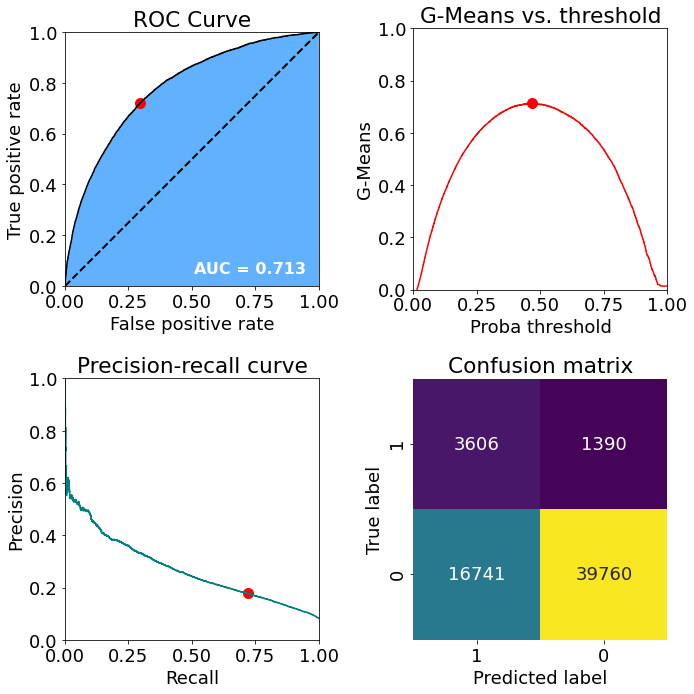

In [101]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics

model = grid.best_estimator_
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# Subject: Optimal threshold for imbalanced classification

# calculate the g-mean for each threshold
# The geometric mean or known as G-mean is the geometric mean of sensitivity (known as recall) and specificity. 
# So, it will be one of the unbiased evaluation metrics for imbalanced classification.
# https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean= optimal threshold
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)


######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean= {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall= {recall:.0%}, \
f1 = {f1:.0%}')
######################################

plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
plt.fill_between(fpr, tpr, facecolor='dodgerblue', alpha=0.7)
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=16, weight='bold', color='white')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.subplot(222)
plt.plot(thresholds, g_means, 'r');
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

plt.subplot(223)
plt.plot(recall_, precision_, 'teal');
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

plt.subplot(224)
sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

## Recovering Top 25 important features to decision == inspiration LerysG

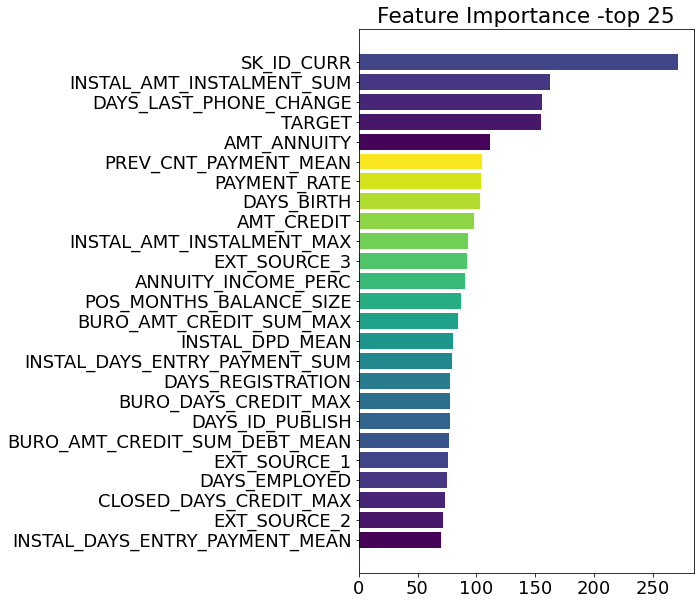

In [102]:
# Recover important features from previous fit and then permute importance

features_list = df.columns

n_feat = 25  # number of feature to show

feature_importance = model.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(6, 10))
plt.barh(pos[-1*n_feat:], feature_importance[sorted_idx]
         [-1*n_feat:], align='center', color=my_colors(20))
plt.yticks(pos[-1*n_feat:], features_list[sorted_idx][-1*n_feat:])
plt.title('Feature Importance -top 25')
plt.show()

In [105]:
features_list = df.columns
features_list

Index(['SK_ID_CURR', 'TARGET', 'PAYMENT_RATE', 'DAYS_BIRTH',
       'PREV_CNT_PAYMENT_MEAN', 'DAYS_EMPLOYED', 'AMT_ANNUITY',
       'INSTAL_AMT_INSTALMENT_SUM', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       ...
       'NAME_INCOME_TYPE_Working', 'PREV_NAME_GOODS_CATEGORY_Computers_MEAN',
       'PREV_CODE_REJECT_REASON_SCO_MEAN', 'PREV_HOUR_APPR_PROCESS_START_MIN',
       'PREV_CHANNEL_TYPE_Countrywide_MEAN', 'CC_AMT_PAYMENT_CURRENT_MAX',
       'PREV_CHANNEL_TYPE_Stone_MEAN', 'CC_NAME_CONTRACT_STATUS_Active_MEAN',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OCCUPATION_TYPE_Corestaff'],
      dtype='object', length=174)

In [181]:
liste_25 = list(features_list[sorted_idx][-25:])
liste_25.reverse()
liste_25

['SK_ID_CURR',
 'INSTAL_AMT_INSTALMENT_SUM',
 'DAYS_LAST_PHONE_CHANGE',
 'TARGET',
 'AMT_ANNUITY',
 'PREV_CNT_PAYMENT_MEAN',
 'PAYMENT_RATE',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'INSTAL_AMT_INSTALMENT_MAX',
 'EXT_SOURCE_3',
 'ANNUITY_INCOME_PERC',
 'POS_MONTHS_BALANCE_SIZE',
 'BURO_AMT_CREDIT_SUM_MAX',
 'INSTAL_DPD_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'DAYS_REGISTRATION',
 'BURO_DAYS_CREDIT_MAX',
 'DAYS_ID_PUBLISH',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'CLOSED_DAYS_CREDIT_MAX',
 'EXT_SOURCE_2',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN']

In [182]:
liste_25.remove('SK_ID_CURR')

['INSTAL_AMT_INSTALMENT_SUM',
 'DAYS_LAST_PHONE_CHANGE',
 'TARGET',
 'AMT_ANNUITY',
 'PREV_CNT_PAYMENT_MEAN',
 'PAYMENT_RATE',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'INSTAL_AMT_INSTALMENT_MAX',
 'EXT_SOURCE_3',
 'ANNUITY_INCOME_PERC',
 'POS_MONTHS_BALANCE_SIZE',
 'BURO_AMT_CREDIT_SUM_MAX',
 'INSTAL_DPD_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'DAYS_REGISTRATION',
 'BURO_DAYS_CREDIT_MAX',
 'DAYS_ID_PUBLISH',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'CLOSED_DAYS_CREDIT_MAX',
 'EXT_SOURCE_2',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN']

In [187]:
liste_25.remove('TARGET')
liste_25

['INSTAL_AMT_INSTALMENT_SUM',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_ANNUITY',
 'PREV_CNT_PAYMENT_MEAN',
 'PAYMENT_RATE',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'INSTAL_AMT_INSTALMENT_MAX',
 'EXT_SOURCE_3',
 'ANNUITY_INCOME_PERC',
 'POS_MONTHS_BALANCE_SIZE',
 'BURO_AMT_CREDIT_SUM_MAX',
 'INSTAL_DPD_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'DAYS_REGISTRATION',
 'BURO_DAYS_CREDIT_MAX',
 'DAYS_ID_PUBLISH',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'CLOSED_DAYS_CREDIT_MAX',
 'EXT_SOURCE_2',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN']

In [188]:
# Sauvegarde les premiers 25 features importantes conservées pour le train_set et test_set
fic_var_features_25 = 'features_25.pickle'
with open(fic_var_features_25, 'wb') as f:
    pickle.dump(liste_25, f, pickle.HIGHEST_PROTOCOL)

In [189]:
# Chargement des variables conservées pour le train_set et test_set
fic_var_features_25 = 'features_25.pickle'
with open('features_25.pickle', 'rb') as fic_var_features_25:
    features_liste_25 = pickle.load(fic_var_features_25)
len(features_liste_25)

23

In [191]:
# features_liste_25

## selection feature_importante pour df_test (prédictions)

In [106]:
# Chargement des variables conservées pour le train_set et test_set
fic_var_features_172 = 'features_172.pickle'
with open('features_172.pickle', 'rb') as fic_var_features_172:
    features_selection_liste_172 = pickle.load(fic_var_features_172)
len(features_selection_liste_172)

172

In [107]:
features_selection_liste_172

['PAYMENT_RATE',
 'DAYS_BIRTH',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'INSTAL_AMT_INSTALMENT_SUM',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'BURO_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_INSTALMENT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'ANNUITY_INCOME_PERC',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_REGISTRATION',
 'POS_MONTHS_BALANCE_SIZE',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'APPROVED_CNT_PAYMENT_SUM',
 'INSTAL_DBD_SUM',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REGION_POPULATION_RELATIVE',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'INSTAL_DBD_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'CODE_GENDER',
 'INCOME_CREDIT_PERC',
 'PREV_APP_CREDIT_PERC_MIN',
 'CC_CNT_DRAWINGS_CURRENT_VAR',
 'PREV_AMT_ANNUITY_MAX',
 'BU

In [108]:
features_selection_liste_172.insert(0, 'SK_ID_CURR')

In [109]:
features_selection_liste_172

['SK_ID_CURR',
 'PAYMENT_RATE',
 'DAYS_BIRTH',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'INSTAL_AMT_INSTALMENT_SUM',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'BURO_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_INSTALMENT_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'ANNUITY_INCOME_PERC',
 'EXT_SOURCE_2',
 'AMT_CREDIT',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_REGISTRATION',
 'POS_MONTHS_BALANCE_SIZE',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'APPROVED_CNT_PAYMENT_SUM',
 'INSTAL_DBD_SUM',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REGION_POPULATION_RELATIVE',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'INSTAL_DBD_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'CODE_GENDER',
 'INCOME_CREDIT_PERC',
 'PREV_APP_CREDIT_PERC_MIN',
 'CC_CNT_DRAWINGS_CURRENT_VAR',
 'PREV_AMT_ANN

In [110]:
len(features_selection_liste_172)

173

In [111]:
df_test = pd.read_csv('df_test_final.csv')

In [112]:
df_test_features_imp_dash =df_test[features_selection_liste_172]

In [113]:
df_test_features_imp_dash

SK_ID_CURR  PAYMENT_RATE  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  \
0          100001      0.036147      -19241               8.000000   
1          100005      0.077973      -18064              12.000000   
2          100013      0.105202      -20038              17.333333   
3          100028      0.031123      -13976              11.333333   
4          100038      0.051266      -13040              24.000000   
...           ...           ...         ...                    ...   
48739      456221      0.042354      -19970              24.000000   
48740      456222      0.051267      -11186              17.500000   
48741      456223      0.105414      -15922              11.000000   
48742      456224      0.055840      -13968              14.500000   
48743      456250      0.079003      -13962              15.600000   

       DAYS_EMPLOYED  AMT_ANNUITY  INSTAL_AMT_INSTALMENT_SUM  EXT_SOURCE_1  \
0            -2329.0      20560.5                  41195.925      0.752614   
1            -4469.0      17370.0                  56161.845      0.564990   
2            -4458.0      69777.0                1689174.270      0.506771   
3            -1866.0      49018.5                 562658.895      0.525734   
4            -2191.0      32067.0                 133204.050      0.202145   
...              ...          ...                        ...           ...   
48739        -5169.0      17473.5                 273109.365      0.506771   
48740        -1149.0      31909.5                 590289.840      0.506771   
48741        -3037.0      33205.5                 185271.930      0.733503   
48742        -2731.0      25128.0                 500807.790      0.373090   
48743         -633.0      24709.5                 661903.155      0.506771   

       EXT_SOURCE_3  BURO_DAYS_CREDIT_MAX  ...  NAME_INCOME_TYPE_Working  \
0          0.159520                 -49.0  ...                         1   
1          0.432962                 -62.0  ...                         1   
2          0.610991               -1210.0  ...                         1   
3          0.612704                -269.0  ...                         1   
4          0.519097                -327.0  ...                         1   
...             ...                   ...  ...                       ...   
48739      0.643026                -113.0  ...                         1   
48740      0.519097                -327.0  ...                         0   
48741      0.283712                -218.0  ...                         0   
48742      0.595456                -515.0  ...                         0   
48743      0.272134                -760.0  ...                         1   

       PREV_NAME_GOODS_CATEGORY_Computers_MEAN  \
0                                        0.000   
1                                        0.000   
2                                        0.250   
3                                        0.200   
4                                        0.500   
...                                        ...   
48739                                    0.000   
48740                                    0.000   
48741                                    0.000   
48742                                    0.000   
48743                                    0.125   

       PREV_CODE_REJECT_REASON_SCO_MEAN  PREV_HOUR_APPR_PROCESS_START_MIN  \
0                                   0.0                              13.0   
1                                   0.0                              10.0   
2                                   0.0                              12.0   
3                                   0.0                               9.0   
4                                   0.0                               4.0   
...                                 ...                               ...   
48739                               0.0                              14.0   
48740                               0.0                              10.0   
48741                 

In [114]:
df_test_features_imp_dash.to_csv('df_test_features_173.csv', index=False)

In [115]:
df_test_dash = pd.read_csv('df_test_features_173.csv')

In [116]:
df_test_dash.shape

(48744, 173)

### <font color="#0000FF" id="section_3_4">3.4. SCORING: Predictions-Probabilités-Données clients</font>

meilleur modèle entraîné sur le jeu d'entraînement est maintenant opérationnel pour effectuer des prédictions et calculer les probabiltés du score de chacun des clients du jeu de test fourni pour Home Crédit.

In [224]:
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = df_test_dash['SK_ID_CURR']
# Préparation de la matrice à soumettre aux prédictions 
X_test = df_test_dash.drop('SK_ID_CURR', axis=1)

In [225]:
# Score des prédictions de probabiltés
y_proba = model.predict_proba(X_test)[:, 1]

In [226]:
y_proba

array([0.3676949 , 0.24266232, 0.17212722, ..., 0.18764237, 0.25475802,
       0.32273269])

In [227]:
# Prédictions pour le client :
# classe 0 : non défaillant, classe 1 : défaillant
y_pred = model.predict(X_test)

In [124]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [228]:
# Constitution du dataframe pour merge
df_score = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE_CLIENT' : y_pred,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_score.head(3)

SK_ID_CURR  PRED_CLASSE_CLIENT  SCORE_CLIENT  SCORE_CLIENT_%
0      100001                   0      0.367695            36.8
1      100005                   0      0.242662            24.3
2      100013                   0      0.172127            17.2

In [229]:
# Ajout des prédictions au dataframe du jeu de test
df_dashboard_1 = df_score.merge(df_test_dash, on='SK_ID_CURR', how='left')
df_dashboard_1.head(3)

SK_ID_CURR  PRED_CLASSE_CLIENT  SCORE_CLIENT  SCORE_CLIENT_%  PAYMENT_RATE  \
0      100001                   0      0.367695            36.8      0.036147   
1      100005                   0      0.242662            24.3      0.077973   
2      100013                   0      0.172127            17.2      0.105202   

   DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  AMT_ANNUITY  \
0      -19241               8.000000        -2329.0      20560.5   
1      -18064              12.000000        -4469.0      17370.0   
2      -20038              17.333333        -4458.0      69777.0   

   INSTAL_AMT_INSTALMENT_SUM  ...  NAME_INCOME_TYPE_Working  \
0                  41195.925  ...                         1   
1                  56161.845  ...                         1   
2                1689174.270  ...                         1   

   PREV_NAME_GOODS_CATEGORY_Computers_MEAN  PREV_CODE_REJECT_REASON_SCO_MEAN  \
0                                     0.00                               0.0   
1                                     0.00                               0.0   
2                                     0.25                               0.0   

   PREV_HOUR_APPR_PROCESS_START_MIN  PREV_CHANNEL_TYPE_Countrywide_MEAN  \
0                              13.0                                 1.0   
1                              10.0                                 0.5   
2                              12.0                                 0.0   

   CC_AMT_PAYMENT_CURRENT_MAX  PREV_CHANNEL_TYPE_Stone_MEAN  \
0                    64205.91                          0.00   
1                    64205.91                          0.00   
2                   153675.00                          0.25   

   CC_NAME_CONTRACT_STATUS_Active_MEAN  OBS_30_CNT_SOCIAL_CIRCLE  \
0                                  1.0                       0.0   
1                                  1.0                       0.0   
2                                  1.0                       0.0   

   OCCUPATION_TYPE_Corestaff  
0                          0  
1                          0  
2                          0  

[3 rows x 176 columns]

In [230]:
# Sauvegarde de df_dashboard_1
fic_sav_df_dashboard_1 ='df_dashboard_1.pickle'
with open(fic_sav_df_dashboard_1, 'wb') as f:
    pickle.dump(df_dashboard_1, f, pickle.HIGHEST_PROTOCOL)

In [232]:
# Chargement du dataframe df_dashboard_1
fic_sav_df_dashboard_1 ='df_dashboard_1.pickle'
with open(fic_sav_df_dashboard_1, 'rb') as df_dashboard_1:
    df_dashboard_1 = pickle.load(df_dashboard_1)
df_dashboard_1.shape

(48744, 176)

### Préparation des données informative

In [233]:
df_test_dash = pd.read_csv('df_test_features_173.csv')

In [234]:
appl_test = pd.read_csv("application_test.csv", delimiter = ",")

Les données informatives sur le client à rendre disponible et lisible pour le chargé de clientèle :

| Variable | Description | Dans test_set et non transformé? |
| --- | --- | --- |
| <p style='text-align: justify; color:green'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> | Oui |
| <p style='text-align: justify; color:green'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> | Oui |
| <p style='text-align: justify; color:red'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> | Non => à  ajouter |
| <p style='text-align: justify; color:orange'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:orange'>**DAYS_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:green'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> | Oui |
| <p style='text-align: justify; color:red'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:orange'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> | Oui mais transformer '0' en 'Féminin' et '1' en 'Masculin' |

In [235]:
df_infos =appl_test[['SK_ID_CURR',
                            'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE']]
df_infos.head(3)

SK_ID_CURR NAME_FAMILY_STATUS  AMT_GOODS_PRICE  CNT_CHILDREN  \
0      100001            Married         450000.0             0   
1      100005            Married         180000.0             0   
2      100013            Married         630000.0             0   

  NAME_CONTRACT_TYPE            NAME_EDUCATION_TYPE  NAME_HOUSING_TYPE  \
0         Cash loans               Higher education  House / apartment   
1         Cash loans  Secondary / secondary special  House / apartment   
2         Cash loans               Higher education  House / apartment   

  NAME_INCOME_TYPE  
0          Working  
1          Working  
2          Working

In [236]:
df_infos.shape

(48744, 8)

In [237]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_dashboard_2 = df_test_dash.merge(df_infos, on='SK_ID_CURR', how='right')
df_dashboard_2.head(3)

SK_ID_CURR  PAYMENT_RATE  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0      100001      0.036147      -19241               8.000000        -2329.0   
1      100005      0.077973      -18064              12.000000        -4469.0   
2      100013      0.105202      -20038              17.333333        -4458.0   

   AMT_ANNUITY  INSTAL_AMT_INSTALMENT_SUM  EXT_SOURCE_1  EXT_SOURCE_3  \
0      20560.5                  41195.925      0.752614      0.159520   
1      17370.0                  56161.845      0.564990      0.432962   
2      69777.0                1689174.270      0.506771      0.610991   

   BURO_DAYS_CREDIT_MAX  ...  CC_NAME_CONTRACT_STATUS_Active_MEAN  \
0                 -49.0  ...                                  1.0   
1                 -62.0  ...                                  1.0   
2               -1210.0  ...                                  1.0   

   OBS_30_CNT_SOCIAL_CIRCLE  OCCUPATION_TYPE_Corestaff  NAME_FAMILY_STATUS  \
0                       0.0                          0             Married   
1                       0.0                          0             Married   
2                       0.0                          0             Married   

   AMT_GOODS_PRICE  CNT_CHILDREN  NAME_CONTRACT_TYPE  \
0         450000.0             0          Cash loans   
1         180000.0             0          Cash loans   
2         630000.0             0          Cash loans   

             NAME_EDUCATION_TYPE  NAME_HOUSING_TYPE  NAME_INCOME_TYPE  
0               Higher education  House / apartment           Working  
1  Secondary / secondary special  House / apartment           Working  
2               Higher education  House / apartment           Working  

[3 rows x 180 columns]

In [238]:
df_test_dash[['CODE_GENDER']].value_counts()

CODE_GENDER
0              32678
1              16066
dtype: int64

**Modification des dates en années au lieu de jours (positif)**

In [239]:
# Transformer DAYS_BIRTH en années positives
df_dashboard_2['YEAR_BIRTH'] = \
    np.trunc(np.abs(df_dashboard_2['DAYS_BIRTH'] / 365)).astype('int8')

In [240]:
# Transformer DAYS_EMPLOYED en années positives
df_dashboard_2['YEAR_EMPLOYED'] = \
    np.trunc(np.abs(df_dashboard_2['DAYS_EMPLOYED'] / 365)).astype('int8')

In [241]:
# Transformer sexe : 0 = Féminin et 1 = Masculin
df_dashboard_2['SEXE'] = ['Feminin' if row == 0 else 'Masculin'
                        for row in df_dashboard_2['CODE_GENDER']] 

In [242]:
df_dashboard_2.head(3)

SK_ID_CURR  PAYMENT_RATE  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0      100001      0.036147      -19241               8.000000        -2329.0   
1      100005      0.077973      -18064              12.000000        -4469.0   
2      100013      0.105202      -20038              17.333333        -4458.0   

   AMT_ANNUITY  INSTAL_AMT_INSTALMENT_SUM  EXT_SOURCE_1  EXT_SOURCE_3  \
0      20560.5                  41195.925      0.752614      0.159520   
1      17370.0                  56161.845      0.564990      0.432962   
2      69777.0                1689174.270      0.506771      0.610991   

   BURO_DAYS_CREDIT_MAX  ...  NAME_FAMILY_STATUS  AMT_GOODS_PRICE  \
0                 -49.0  ...             Married         450000.0   
1                 -62.0  ...             Married         180000.0   
2               -1210.0  ...             Married         630000.0   

   CNT_CHILDREN  NAME_CONTRACT_TYPE            NAME_EDUCATION_TYPE  \
0             0          Cash loans               Higher education   
1             0          Cash loans  Secondary / secondary special   
2             0          Cash loans               Higher education   

   NAME_HOUSING_TYPE  NAME_INCOME_TYPE  YEAR_BIRTH  YEAR_EMPLOYED      SEXE  
0  House / apartment           Working          52              6   Feminin  
1  House / apartment           Working          49             12  Masculin  
2  House / apartment           Working          54             12  Masculin  

[3 rows x 183 columns]

In [243]:
df_dashboard_2.shape

(48744, 183)

In [244]:
# Sauvegarde de df_dashboard_2
fic_sav_df_dashboard_2 ='df_dashboard_2.pickle'
with open(fic_sav_df_dashboard_2, 'wb') as f:
    pickle.dump(df_dashboard_2, f, pickle.HIGHEST_PROTOCOL)

In [245]:
# Chargement du dataframe df_dashboard_2
fic_sav_df_dashboard_2 ='df_dashboard_2.pickle'
with open(fic_sav_df_dashboard_2, 'rb') as df_dashboard_2:
    df_dashboard_2 = pickle.load(df_dashboard_2)
df_dashboard_2.shape

(48744, 183)

### Préparation des graphiques

### Informations générales

Les données informatives à afficher une fois le client sélectionner :

- sur les traits stricts du client :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**YEAR_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**SEXE**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> |
| <p style='text-align: justify;'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> |
| <p style='text-align: justify;'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> |
| <p style='text-align: justify;'>**YEAR_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> |
| <p style='text-align: justify;'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> |

- sur le prêt :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> |
| <p style='text-align: justify;'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> |
| <p style='text-align: justify;'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> |
| <p style='text-align: justify;'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> 

#### **Traits stricts du client**

In [246]:
# Traits stricts du client
df_info_client = df_dashboard_2[['SK_ID_CURR', 'YEAR_BIRTH', 'SEXE',
                               'NAME_FAMILY_STATUS',
                               'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                               'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                               'AMT_INCOME_TOTAL']]

In [247]:
df_info_client = df_info_client.rename(columns = {
     'YEAR_BIRTH' : 'Âge (ans)',
     'SEXE' : 'Sexe',
     'NAME_FAMILY_STATUS' : 'Statut familial',
     'CNT_CHILDREN' : 'Nbre enfants',
     'NAME_EDUCATION_TYPE' : 'Niveau éducation',
     'NAME_INCOME_TYPE' : 'Type revenu',
     'YEAR_EMPLOYED' : "Anciennete (ans)",
     'AMT_INCOME_TOTAL' : 'Revenus ($)'})
df_info_client.head(3)

SK_ID_CURR  Âge (ans)      Sexe Statut familial  Nbre enfants  \
0      100001         52   Feminin         Married             0   
1      100005         49  Masculin         Married             0   
2      100013         54  Masculin         Married             0   

                Niveau éducation Type revenu  Anciennete (ans)  Revenus ($)  
0               Higher education     Working                 6     135000.0  
1  Secondary / secondary special     Working                12      99000.0  
2               Higher education     Working                12     202500.0

In [248]:
# Sauvegarde de df_info_client
fic_sav_df_info_client ='df_info_client.pickle'
with open(fic_sav_df_info_client, 'wb') as f:
    pickle.dump(df_info_client, f, pickle.HIGHEST_PROTOCOL)

In [249]:
# Chargement du dataframe df_info_client
fic_sav_df_info_client ='df_info_client.pickle'
with open(fic_sav_df_info_client, 'rb') as df_info_client:
    df_info_client = pickle.load(df_info_client)
df_info_client.shape

(48744, 9)

In [250]:
df_info_client

SK_ID_CURR  Âge (ans)      Sexe Statut familial  Nbre enfants  \
0          100001         52   Feminin         Married             0   
1          100005         49  Masculin         Married             0   
2          100013         54  Masculin         Married             0   
3          100028         38   Feminin         Married             2   
4          100038         35  Masculin         Married             1   
...           ...        ...       ...             ...           ...   
48739      456221         54   Feminin           Widow             0   
48740      456222         30   Feminin         Married             2   
48741      456223         43   Feminin         Married             1   
48742      456224         38  Masculin         Married             0   
48743      456250         38   Feminin         Married             0   

                    Niveau éducation           Type revenu  Anciennete (ans)  \
0                   Higher education               Working                 6   
1      Secondary / secondary special               Working                12   
2                   Higher education               Working                12   
3      Secondary / secondary special               Working                 5   
4      Secondary / secondary special               Working                 6   
...                              ...                   ...               ...   
48739  Secondary / secondary special               Working                14   
48740  Secondary / secondary special  Commercial associate                 3   
48741  Secondary / secondary special  Commercial associate                 8   
48742               Higher education  Commercial associate                 7   
48743  Secondary / secondary special               Working                 1   

       Revenus ($)  
0         135000.0  
1          99000.0  
2         202500.0  
3         315000.0  
4         180000.0  
...            ...  
48739     121500.0  
48740     157500.0  
48741     202500.0  
48742     225000.0  
48743     135000.0  

[48744 rows x 9 columns]

### **Informations sur la demande de prêt du client**

In [251]:
# Informations sur la demande prêt
df_pret_client = df_dashboard_2[['SK_ID_CURR', 'NAME_CONTRACT_TYPE',
                               'AMT_CREDIT',
                               'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                               'NAME_HOUSING_TYPE']]

In [252]:
df_pret_client = df_pret_client.rename(columns = {
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_client.head(3)

SK_ID_CURR Type de prêt  Montant du crédit ($)  Annuités ($)  \
0      100001   Cash loans               568800.0       20560.5   
1      100005   Cash loans               222768.0       17370.0   
2      100013   Cash loans               663264.0       69777.0   

   Montant du bien ($)   Type de logement  
0             450000.0  House / apartment  
1             180000.0  House / apartment  
2             630000.0  House / apartment

In [253]:
# Sauvegarde de df_pret_client
fic_sav_df_pret_client ='df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'wb') as f:
    pickle.dump(df_pret_client, f, pickle.HIGHEST_PROTOCOL)

In [254]:
# Chargement du dataframe df_pret_client
fic_sav_df_pret_client ='df_pret_client.pickle'
with open(fic_sav_df_pret_client, 'rb') as df_pret_client:
    df_pret_client = pickle.load(df_pret_client)
df_pret_client.shape

(48744, 6)

In [255]:
df_pret_client

SK_ID_CURR Type de prêt  Montant du crédit ($)  Annuités ($)  \
0          100001   Cash loans               568800.0       20560.5   
1          100005   Cash loans               222768.0       17370.0   
2          100013   Cash loans               663264.0       69777.0   
3          100028   Cash loans              1575000.0       49018.5   
4          100038   Cash loans               625500.0       32067.0   
...           ...          ...                    ...           ...   
48739      456221   Cash loans               412560.0       17473.5   
48740      456222   Cash loans               622413.0       31909.5   
48741      456223   Cash loans               315000.0       33205.5   
48742      456224   Cash loans               450000.0       25128.0   
48743      456250   Cash loans               312768.0       24709.5   

       Montant du bien ($)   Type de logement  
0                 450000.0  House / apartment  
1                 180000.0  House / apartment  
2                 630000.0  House / apartment  
3                1575000.0  House / apartment  
4                 625500.0  House / apartment  
...                    ...                ...  
48739             270000.0  House / apartment  
48740             495000.0  House / apartment  
48741             315000.0  House / apartment  
48742             450000.0  House / apartment  
48743             270000.0  House / apartment  

[48744 rows x 6 columns]

## Score du client

**Prédiction pour un client**

In [256]:
# Sélection des variables du clients
client_id = 100001
X_test = df_dashboard_1[df_dashboard_1['SK_ID_CURR'] == client_id]
X_test

SK_ID_CURR  PRED_CLASSE_CLIENT  SCORE_CLIENT  SCORE_CLIENT_%  PAYMENT_RATE  \
0      100001                   0      0.367695            36.8      0.036147   

   DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  AMT_ANNUITY  \
0      -19241                    8.0        -2329.0      20560.5   

   INSTAL_AMT_INSTALMENT_SUM  ...  NAME_INCOME_TYPE_Working  \
0                  41195.925  ...                         1   

   PREV_NAME_GOODS_CATEGORY_Computers_MEAN  PREV_CODE_REJECT_REASON_SCO_MEAN  \
0                                      0.0                               0.0   

   PREV_HOUR_APPR_PROCESS_START_MIN  PREV_CHANNEL_TYPE_Countrywide_MEAN  \
0                              13.0                                 1.0   

   CC_AMT_PAYMENT_CURRENT_MAX  PREV_CHANNEL_TYPE_Stone_MEAN  \
0                    64205.91                           0.0   

   CC_NAME_CONTRACT_STATUS_Active_MEAN  OBS_30_CNT_SOCIAL_CIRCLE  \
0                                  1.0                       0.0   

   OCCUPATION_TYPE_Corestaff  
0                          0  

[1 rows x 176 columns]

In [279]:
y_proba_client_id = X_test['SCORE_CLIENT_%'][0]
y_proba_client_id

36.8

**Jauge pour le score du client**

In [288]:
# https://plotly.com/python/gauge-charts/
import plotly.graph_objects as go

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = y_proba_client_id,
    mode = "gauge+number+delta",
    title = {'text': 'Crédit score du client', 'font': {'size': 24}},
    delta = {'reference': 71,
             'increasing': {'color': 'Crimson'},
             'decreasing': {'color': 'Green'}},
    gauge = {'axis': {'range': [None, 100],
                      'tickwidth': 3,
                      'tickcolor': 'darkblue'},
             'bar': {'color': 'white', 'thickness' : 0.25},
             'steps': [{'range': [0, 25], 'color': 'Green'},
                       {'range': [25, 49.49], 'color': 'LimeGreen'},
                       {'range': [49.5, 50.5], 'color': 'red'},
                       {'range': [50.51, 75], 'color': 'Orange'},
                       {'range': [75, 100], 'color': 'Crimson'}],
             'threshold': {'line': {'color': 'white', 'width': 10},
                            'thickness': 0.75, 'value': y_proba_client_id}}))

fig.show()